In [1]:
# Importing libraries

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
%matplotlib inline

import matplotlib.cm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler


import statsmodels.api as sm

## Reading Data

In [2]:
df = pd.read_csv('kc_house_data.csv')

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Encoding view into separate features

In [3]:
df = pd.concat([df,pd.get_dummies(df['view'], prefix='view', drop_first=True)],axis=1).drop(['view'],axis=1)

df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,view_1.0,view_2.0,view_3.0,view_4.0
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,3,...,0.0,98178,47.5112,-122.257,1340,5650,0,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,...,1991.0,98125,47.7210,-122.319,1690,7639,0,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,...,NaN,98028,47.7379,-122.233,2720,8062,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,...,0.0,98136,47.5208,-122.393,1360,5000,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,...,0.0,98074,47.6168,-122.045,1800,7503,0,0,0,0
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,3,...,0.0,98053,47.6561,-122.005,4760,101930,0,0,0,0
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,3,...,0.0,98003,47.3097,-122.327,2238,6819,0,0,0,0
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,3,...,0.0,98198,47.4095,-122.315,1650,9711,0,0,0,0
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,3,...,0.0,98146,47.5123,-122.337,1780,8113,0,0,0,0
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,3,...,0.0,98038,47.3684,-122.031,2390,7570,0,0,0,0


## Waterfront is the next variable of interest - and mostly 0, so imputing NaN with 0s

In [4]:
df['waterfront'] = df['waterfront'].fillna(0)

df['waterfront'].value_counts(dropna=False)

0.0    21451
1.0      146
Name: waterfront, dtype: int64

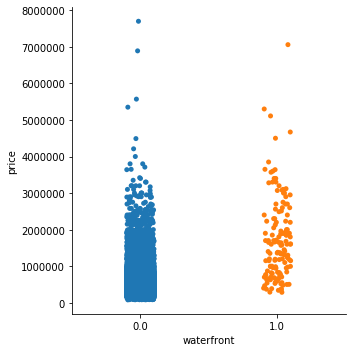

In [5]:
sns.catplot(x="waterfront", y="price",data=df)

## Keeping yr_renovated, filling with 0s, creating new features off of yr_renovated

In [6]:
df['yr_renovated'] = df['yr_renovated'].fillna(0)

## Extract only housing that was renovated, as well as the gap between building and renovation in years

In [7]:
df['was_renovated'] = df['yr_renovated'].astype(bool).astype(int)
renovation_gap = df[(df['yr_renovated'] > 0)]
display(renovation_gap.head(10))
display(df.head(10))

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,view_1.0,view_2.0,view_3.0,view_4.0,was_renovated
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,...,98125,47.7210,-122.319,1690,7639,0,0,0,0,1
35,9547205180,6/13/2014,696000.0,3,2.50,2300,3060,1.5,0.0,3,...,98115,47.6827,-122.310,1590,3264,0,0,0,0,1
95,1483300570,9/8/2014,905000.0,4,2.50,3300,10250,1.0,0.0,3,...,98040,47.5873,-122.249,1950,6045,0,0,0,0,1
103,2450000295,10/7/2014,1090000.0,3,2.50,2920,8113,2.0,0.0,3,...,98004,47.5814,-122.196,2370,8113,0,0,0,0,1
125,4389200955,3/2/2015,1450000.0,4,2.75,2750,17789,1.5,0.0,3,...,98004,47.6141,-122.212,3060,11275,0,0,0,0,1
158,8029200135,11/13/2014,247000.0,3,2.00,1270,7198,1.5,0.0,3,...,98022,47.2086,-121.996,1160,7198,0,0,0,0,1
209,6300000550,7/17/2014,464000.0,6,3.00,2300,3404,2.0,0.0,3,...,98133,47.7067,-122.343,1560,1312,0,0,0,0,1
216,46100204,2/21/2015,1510000.0,5,3.00,3300,33474,1.0,0.0,3,...,98040,47.5673,-122.210,3836,20953,0,0,1,0,1
230,8096000060,4/13/2015,655000.0,2,1.75,1450,15798,2.0,1.0,3,...,98166,47.4497,-122.375,2030,13193,0,0,0,1,1
237,7228500560,3/20/2015,410000.0,4,1.00,1970,4740,1.5,0.0,3,...,98122,47.6136,-122.303,1510,4740,0,0,0,0,1


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,view_1.0,view_2.0,view_3.0,view_4.0,was_renovated
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,3,...,98178,47.5112,-122.257,1340,5650,0,0,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,...,98125,47.7210,-122.319,1690,7639,0,0,0,0,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,...,98028,47.7379,-122.233,2720,8062,0,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,...,98136,47.5208,-122.393,1360,5000,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,...,98074,47.6168,-122.045,1800,7503,0,0,0,0,0
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,3,...,98053,47.6561,-122.005,4760,101930,0,0,0,0,0
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,3,...,98003,47.3097,-122.327,2238,6819,0,0,0,0,0
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,3,...,98198,47.4095,-122.315,1650,9711,0,0,0,0,0
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,3,...,98146,47.5123,-122.337,1780,8113,0,0,0,0,0
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,3,...,98038,47.3684,-122.031,2390,7570,0,0,0,0,0


In [8]:
df['was_renovated'].value_counts()

0    20853
1      744
Name: was_renovated, dtype: int64

In [9]:
renovation_gap['ren_gap'] = renovation_gap["yr_renovated"] - renovation_gap["yr_built"]

renovation_gap['ren_gap'].value_counts(dropna=False)

C:\Users\reube\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


63.0     17
43.0     17
37.0     16
36.0     15
61.0     15
         ..
105.0     1
13.0      1
109.0     1
113.0     1
10.0      1
Name: ren_gap, Length: 103, dtype: int64

In [10]:
df['ren_gap'] = renovation_gap['ren_gap']

In [11]:
df['ren_gap'] = df['ren_gap'].fillna(0)

df['ren_gap'].value_counts(dropna=False)

0.0      20853
63.0        17
43.0        17
37.0        16
86.0        15
         ...  
10.0         1
105.0        1
113.0        1
13.0         1
109.0        1
Name: ren_gap, Length: 104, dtype: int64

## Scatterplot of the renovation gap in years among renovated housing vs. year built and its correlation to price

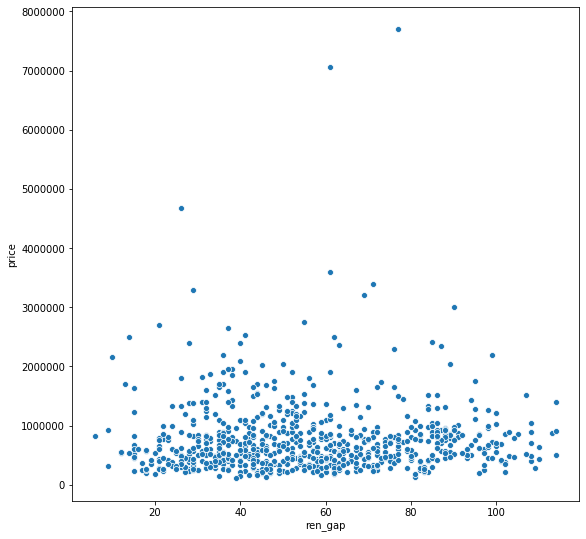

In [12]:
plt.figure(1, figsize=(20,20))
    
plt.subplot(2, 2,1)
sns.scatterplot(x='ren_gap', y='price', data=renovation_gap)

## Seems to be a relatively random distribution, not indicating the linearity we're looking for out of a variable to model, or a good correlation

## Dropping id as it provides no real analysis driving information

In [13]:
df.drop('id', axis=1, inplace=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,lat,long,sqft_living15,sqft_lot15,view_1.0,view_2.0,view_3.0,view_4.0,was_renovated,ren_gap
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,...,47.5112,-122.257,1340,5650,0,0,0,0,0,0.0
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,...,47.7210,-122.319,1690,7639,0,0,0,0,1,40.0
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,6,...,47.7379,-122.233,2720,8062,0,0,0,0,0,0.0
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,...,47.5208,-122.393,1360,5000,0,0,0,0,0,0.0
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,...,47.6168,-122.045,1800,7503,0,0,0,0,0,0.0


## Date dropped, to be revisited for time series analysis

In [14]:
df.drop('date', axis=1, inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,view_1.0,view_2.0,view_3.0,view_4.0,was_renovated,ren_gap
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,...,47.5112,-122.257,1340,5650,0,0,0,0,0,0.0
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,...,47.7210,-122.319,1690,7639,0,0,0,0,1,40.0
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,...,47.7379,-122.233,2720,8062,0,0,0,0,0,0.0
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,...,47.5208,-122.393,1360,5000,0,0,0,0,0,0.0
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,...,47.6168,-122.045,1800,7503,0,0,0,0,0,0.0


## Imputing 0s and converting to int sqft_basement, which is also mostly 0s

In [15]:
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2810.0        1
516.0         1
1798.0        1
2250.0        1
243.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [16]:
df.sqft_basement[df.sqft_basement == "?"] = 0

df['sqft_basement'].value_counts()

C:\Users\reube\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.0       12826
0           454
600.0       217
500.0       209
700.0       208
          ...  
792.0         1
283.0         1
243.0         1
2350.0        1
3500.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [17]:
df['sqft_basement'] = df['sqft_basement'].astype('float32').astype(int)

df['sqft_basement'].value_counts()

0       13280
600       217
500       209
700       208
800       201
        ...  
1816        1
1880        1
1960        1
2120        1
1135        1
Name: sqft_basement, Length: 303, dtype: int64

## Creating boolean of has_basement

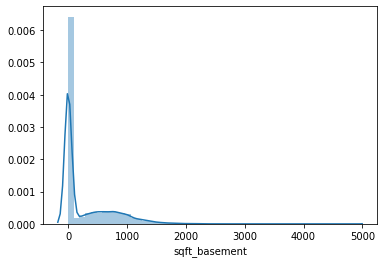

In [18]:
sns.distplot(df['sqft_basement'])

## Most homes don't have a basement, those that have more than 1000 square footage of basement are rare

In [19]:
df['has_basement'] = df['sqft_basement'].astype(bool).astype(int)

In [20]:
df['has_basement'].value_counts()

0    13280
1     8317
Name: has_basement, dtype: int64

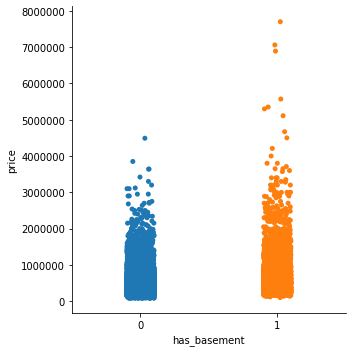

In [21]:
sns.catplot(x='has_basement', y='price', data=df)

## Looks like more dwellings with basements fetch higher prices
## Question: What's the relative impact of years since a house was built, year renovated if it was renovated, years since renovations took place, and whether it was renovated or not on housing prices?

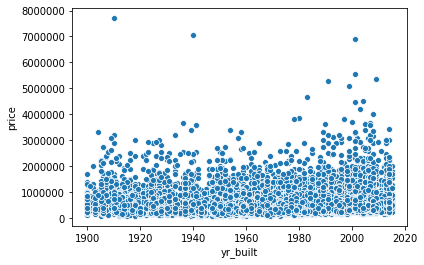

In [22]:
sns.scatterplot(x="yr_built", y='price', data=df)

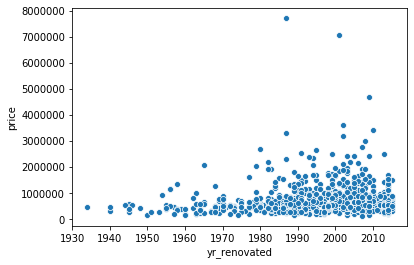

In [23]:
sns.scatterplot(x="yr_renovated", y="price", data= renovation_gap)

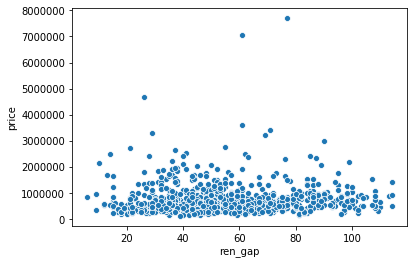

In [24]:
sns.scatterplot(x='ren_gap', y='price', data=renovation_gap)

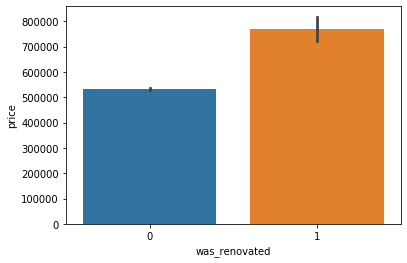

In [25]:
sns.barplot(x='was_renovated', y='price', data=df)

## Conclusions: When a house was built matters less than its renovation year if it was renovated when comparing to price, but it's not that important how many years since a house was built that it was renovated. Renovation overall does raise prices.¶
## Question - how does living in the Seattle area effect prices?

In [26]:
seattlezips = [98188,98199,98174,98154,98158,98164,98101,98102,98103,98104,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98121,98122,98125,98126,98133,98134,98136,
98144]

df['seattle'] = df['zipcode'].apply(lambda i: 1 if i in seattlezips else 0)

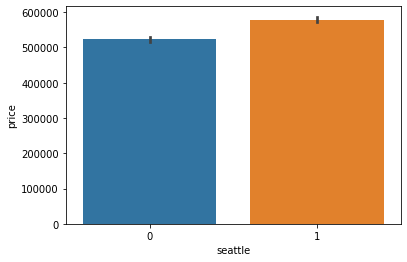

In [27]:
sns.barplot(x='seattle', y='price', data=df)

## Looks like living in Seattle has a measurable impact on driving up price

In [28]:
%%HTML 

<div class='tableauPlaceholder' id='viz1574011490209' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ho&#47;HousingPricesHeatmap-KingCountyWA&#47;kc_housing_heatmap&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='HousingPricesHeatmap-KingCountyWA&#47;kc_housing_heatmap' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ho&#47;HousingPricesHeatmap-KingCountyWA&#47;kc_housing_heatmap&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1574011490209');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## Conclusions - looks like at the least, more expensive homes are spread more in the north and center of the county

## lat and long are mostly useful for geospatial analysis, dropping them for now

In [29]:
df.drop(['lat', 'long'], axis=1, inplace=True)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,...,sqft_living15,sqft_lot15,view_1.0,view_2.0,view_3.0,view_4.0,was_renovated,ren_gap,has_basement,seattle
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,...,1340,5650,0,0,0,0,0,0.0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,...,1690,7639,0,0,0,0,1,40.0,1,1
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,...,2720,8062,0,0,0,0,0,0.0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,...,1360,5000,0,0,0,0,0,0.0,1,1
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,...,1800,7503,0,0,0,0,0,0.0,0,0


## QUESTION: Are there any other issues such as a predominance of 0s in the values of a column? - Bedrooms and Bathrooms look ordinal, as does floors and condition and grade but bathrooms, bedrooms and grade could be treated as numeric

In [30]:
for col in df:
    print(df[col].value_counts(dropna=False))

350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64
1300    138
1400    135
1440    133
1660    129
1010    129
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64
5000      358
6000      290
4000      

In [31]:
df = pd.concat([df,pd.get_dummies(df['condition'], prefix='condition', drop_first=True)],axis=1).drop(['condition'],axis=1)

df.head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,...,view_3.0,view_4.0,was_renovated,ren_gap,has_basement,seattle,condition_2,condition_3,condition_4,condition_5
0,221900.0,3,1.00,1180,5650,1.0,0.0,7,1180,0,...,0,0,0,0.0,0,0,0,1,0,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,7,2170,400,...,0,0,1,40.0,1,1,0,1,0,0
2,180000.0,2,1.00,770,10000,1.0,0.0,6,770,0,...,0,0,0,0.0,0,0,0,1,0,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,7,1050,910,...,0,0,0,0.0,1,1,0,0,0,1
4,510000.0,3,2.00,1680,8080,1.0,0.0,8,1680,0,...,0,0,0,0.0,0,0,0,1,0,0
5,1230000.0,4,4.50,5420,101930,1.0,0.0,11,3890,1530,...,0,0,0,0.0,1,0,0,1,0,0
6,257500.0,3,2.25,1715,6819,2.0,0.0,7,1715,0,...,0,0,0,0.0,0,0,0,1,0,0
7,291850.0,3,1.50,1060,9711,1.0,0.0,7,1060,0,...,0,0,0,0.0,0,0,0,1,0,0
8,229500.0,3,1.00,1780,7470,1.0,0.0,7,1050,730,...,0,0,0,0.0,1,0,0,1,0,0
9,323000.0,3,2.50,1890,6560,2.0,0.0,7,1890,0,...,0,0,0,0.0,0,0,0,1,0,0


## Bedrooms --> categories

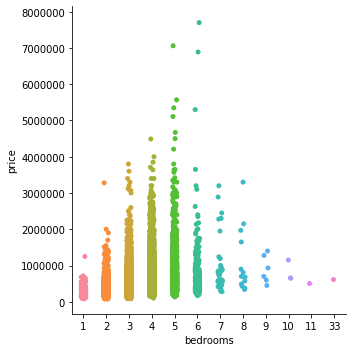

In [32]:
sns.catplot(x='bedrooms', y='price', data=df)

In [33]:
df = pd.concat([df,pd.get_dummies(df['bedrooms'], prefix='bedroom', drop_first=True)],axis=1).drop(['bedrooms'],axis=1)

df.head(10)

,price,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,yr_built,...,bedroom_3,bedroom_4,bedroom_5,bedroom_6,bedroom_7,bedroom_8,bedroom_9,bedroom_10,bedroom_11,bedroom_33
0,221900.0,1.00,1180,5650,1.0,0.0,7,1180,0,1955,...,1,0,0,0,0,0,0,0,0,0
1,538000.0,2.25,2570,7242,2.0,0.0,7,2170,400,1951,...,1,0,0,0,0,0,0,0,0,0
2,180000.0,1.00,770,10000,1.0,0.0,6,770,0,1933,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,3.00,1960,5000,1.0,0.0,7,1050,910,1965,...,0,1,0,0,0,0,0,0,0,0
4,510000.0,2.00,1680,8080,1.0,0.0,8,1680,0,1987,...,1,0,0,0,0,0,0,0,0,0
5,1230000.0,4.50,5420,101930,1.0,0.0,11,3890,1530,2001,...,0,1,0,0,0,0,0,0,0,0
6,257500.0,2.25,1715,6819,2.0,0.0,7,1715,0,1995,...,1,0,0,0,0,0,0,0,0,0
7,291850.0,1.50,1060,9711,1.0,0.0,7,1060,0,1963,...,1,0,0,0,0,0,0,0,0,0
8,229500.0,1.00,1780,7470,1.0,0.0,7,1050,730,1960,...,1,0,0,0,0,0,0,0,0,0
9,323000.0,2.50,1890,6560,2.0,0.0,7,1890,0,2003,...,1,0,0,0,0,0,0,0,0,0


## Binning bathrooms into an ordinal category with .cat.codes

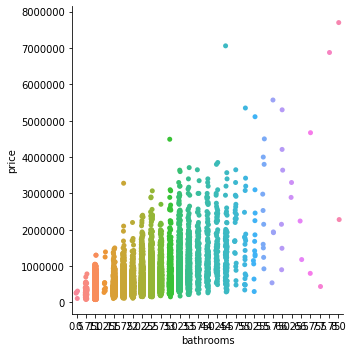

In [34]:
sns.catplot(x="bathrooms", y="price", data=df)

In [35]:
bins = [0, 1,2,3,4,5, 6, 7, 8]
df['bathroom_bins'] = pd.cut(df['bathrooms'], bins,include_lowest = True)

df.head(10)

,price,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,yr_built,...,bedroom_4,bedroom_5,bedroom_6,bedroom_7,bedroom_8,bedroom_9,bedroom_10,bedroom_11,bedroom_33,bathroom_bins
0,221900.0,1.00,1180,5650,1.0,0.0,7,1180,0,1955,...,0,0,0,0,0,0,0,0,0,"(-0.001, 1.0]"
1,538000.0,2.25,2570,7242,2.0,0.0,7,2170,400,1951,...,0,0,0,0,0,0,0,0,0,"(2.0, 3.0]"
2,180000.0,1.00,770,10000,1.0,0.0,6,770,0,1933,...,0,0,0,0,0,0,0,0,0,"(-0.001, 1.0]"
3,604000.0,3.00,1960,5000,1.0,0.0,7,1050,910,1965,...,1,0,0,0,0,0,0,0,0,"(2.0, 3.0]"
4,510000.0,2.00,1680,8080,1.0,0.0,8,1680,0,1987,...,0,0,0,0,0,0,0,0,0,"(1.0, 2.0]"
5,1230000.0,4.50,5420,101930,1.0,0.0,11,3890,1530,2001,...,1,0,0,0,0,0,0,0,0,"(4.0, 5.0]"
6,257500.0,2.25,1715,6819,2.0,0.0,7,1715,0,1995,...,0,0,0,0,0,0,0,0,0,"(2.0, 3.0]"
7,291850.0,1.50,1060,9711,1.0,0.0,7,1060,0,1963,...,0,0,0,0,0,0,0,0,0,"(1.0, 2.0]"
8,229500.0,1.00,1780,7470,1.0,0.0,7,1050,730,1960,...,0,0,0,0,0,0,0,0,0,"(-0.001, 1.0]"
9,323000.0,2.50,1890,6560,2.0,0.0,7,1890,0,2003,...,0,0,0,0,0,0,0,0,0,"(2.0, 3.0]"


In [36]:
df.bathroom_bins.value_counts(dropna=False)

(2.0, 3.0]       9362
(1.0, 2.0]       6432
(-0.001, 1.0]    3926
(3.0, 4.0]       1611
(4.0, 5.0]        223
(5.0, 6.0]         33
(6.0, 7.0]          6
(7.0, 8.0]          4
Name: bathroom_bins, dtype: int64

In [37]:
df['bathroom_bins'] = df['bathroom_bins'].cat.codes

In [38]:
df['bathroom_bins'].value_counts()

2    9362
1    6432
0    3926
3    1611
4     223
5      33
6       6
7       4
Name: bathroom_bins, dtype: int64

In [39]:
df.drop('bathrooms', axis= 1, inplace=True)

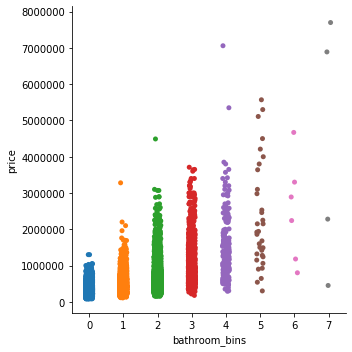

In [40]:
sns.catplot(x="bathroom_bins", y="price", data=df)

## Conclusions: Having 0-4 bedrooms is most common, with 3-4 bedrooms looking like the sweet spot to increase price.

## Encoding of Floors

In [41]:
df = pd.concat([df,pd.get_dummies(df['floors'], prefix='floors', drop_first=True)],axis=1).drop(['floors'],axis=1)

df.head(10)

,price,sqft_living,sqft_lot,waterfront,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,...,bedroom_9,bedroom_10,bedroom_11,bedroom_33,bathroom_bins,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
0,221900.0,1180,5650,0.0,7,1180,0,1955,0.0,98178,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,2570,7242,0.0,7,2170,400,1951,1991.0,98125,...,0,0,0,0,2,0,1,0,0,0
2,180000.0,770,10000,0.0,6,770,0,1933,0.0,98028,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,1960,5000,0.0,7,1050,910,1965,0.0,98136,...,0,0,0,0,2,0,0,0,0,0
4,510000.0,1680,8080,0.0,8,1680,0,1987,0.0,98074,...,0,0,0,0,1,0,0,0,0,0
5,1230000.0,5420,101930,0.0,11,3890,1530,2001,0.0,98053,...,0,0,0,0,4,0,0,0,0,0
6,257500.0,1715,6819,0.0,7,1715,0,1995,0.0,98003,...,0,0,0,0,2,0,1,0,0,0
7,291850.0,1060,9711,0.0,7,1060,0,1963,0.0,98198,...,0,0,0,0,1,0,0,0,0,0
8,229500.0,1780,7470,0.0,7,1050,730,1960,0.0,98146,...,0,0,0,0,0,0,0,0,0,0
9,323000.0,1890,6560,0.0,7,1890,0,2003,0.0,98038,...,0,0,0,0,2,0,1,0,0,0


In [42]:
df.columns

Index(['price', 'sqft_living', 'sqft_lot', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'view_1.0', 'view_2.0', 'view_3.0', 'view_4.0',
       'was_renovated', 'ren_gap', 'has_basement', 'seattle', 'condition_2',
       'condition_3', 'condition_4', 'condition_5', 'bedroom_2', 'bedroom_3',
       'bedroom_4', 'bedroom_5', 'bedroom_6', 'bedroom_7', 'bedroom_8',
       'bedroom_9', 'bedroom_10', 'bedroom_11', 'bedroom_33', 'bathroom_bins',
       'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0', 'floors_3.5'],
      dtype='object')

## Encoding of zipcodes!

In [43]:
df = pd.concat([df,pd.get_dummies(df['zipcode'], prefix='zip',drop_first=True)],axis=1,).drop(['zipcode'],axis=1)

df.head(10)

,price,sqft_living,sqft_lot,waterfront,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,221900.0,1180,5650,0.0,7,1180,0,1955,0.0,1340,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,2570,7242,0.0,7,2170,400,1951,1991.0,1690,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,770,10000,0.0,6,770,0,1933,0.0,2720,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,1960,5000,0.0,7,1050,910,1965,0.0,1360,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,1680,8080,0.0,8,1680,0,1987,0.0,1800,...,0,0,0,0,0,0,0,0,0,0
5,1230000.0,5420,101930,0.0,11,3890,1530,2001,0.0,4760,...,0,0,0,0,0,0,0,0,0,0
6,257500.0,1715,6819,0.0,7,1715,0,1995,0.0,2238,...,0,0,0,0,0,0,0,0,0,0
7,291850.0,1060,9711,0.0,7,1060,0,1963,0.0,1650,...,0,0,0,0,0,0,0,0,1,0
8,229500.0,1780,7470,0.0,7,1050,730,1960,0.0,1780,...,1,0,0,0,0,0,0,0,0,0
9,323000.0,1890,6560,0.0,7,1890,0,2003,0.0,2390,...,0,0,0,0,0,0,0,0,0,0


In [44]:
zip_col = [col for col in df if col.startswith('zip') or col.startswith('price')]
zip_col

['price',
 'zip_98002',
 'zip_98003',
 'zip_98004',
 'zip_98005',
 'zip_98006',
 'zip_98007',
 'zip_98008',
 'zip_98010',
 'zip_98011',
 'zip_98014',
 'zip_98019',
 'zip_98022',
 'zip_98023',
 'zip_98024',
 'zip_98027',
 'zip_98028',
 'zip_98029',
 'zip_98030',
 'zip_98031',
 'zip_98032',
 'zip_98033',
 'zip_98034',
 'zip_98038',
 'zip_98039',
 'zip_98040',
 'zip_98042',
 'zip_98045',
 'zip_98052',
 'zip_98053',
 'zip_98055',
 'zip_98056',
 'zip_98058',
 'zip_98059',
 'zip_98065',
 'zip_98070',
 'zip_98072',
 'zip_98074',
 'zip_98075',
 'zip_98077',
 'zip_98092',
 'zip_98102',
 'zip_98103',
 'zip_98105',
 'zip_98106',
 'zip_98107',
 'zip_98108',
 'zip_98109',
 'zip_98112',
 'zip_98115',
 'zip_98116',
 'zip_98117',
 'zip_98118',
 'zip_98119',
 'zip_98122',
 'zip_98125',
 'zip_98126',
 'zip_98133',
 'zip_98136',
 'zip_98144',
 'zip_98146',
 'zip_98148',
 'zip_98155',
 'zip_98166',
 'zip_98168',
 'zip_98177',
 'zip_98178',
 'zip_98188',
 'zip_98198',
 'zip_98199']

In [45]:
len(zip_col)

70

In [46]:
sorted(df['yr_built'].unique())

[1900,
 1901,
 1902,
 1903,
 1904,
 1905,
 1906,
 1907,
 1908,
 1909,
 1910,
 1911,
 1912,
 1913,
 1914,
 1915,
 1916,
 1917,
 1918,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015]

In [47]:
bins = [1900,1920,1940,1960,1980,2000,2020]
df['yr_built_bins'] = pd.cut(df['yr_built'], bins,include_lowest=True)
df['yr_built_bins']

0        (1940.0, 1960.0]
1        (1940.0, 1960.0]
2        (1920.0, 1940.0]
3        (1960.0, 1980.0]
4        (1980.0, 2000.0]
               ...       
21592    (2000.0, 2020.0]
21593    (2000.0, 2020.0]
21594    (2000.0, 2020.0]
21595    (2000.0, 2020.0]
21596    (2000.0, 2020.0]
Name: yr_built_bins, Length: 21597, dtype: category
Categories (6, interval[float64]): [(1899.999, 1920.0] < (1920.0, 1940.0] < (1940.0, 1960.0] < (1960.0, 1980.0] < (1980.0, 2000.0] < (2000.0, 2020.0]]

In [48]:
df['yr_built_bins'].value_counts()

(1960.0, 1980.0]      4935
(2000.0, 2020.0]      4538
(1980.0, 2000.0]      4491
(1940.0, 1960.0]      4305
(1920.0, 1940.0]      1780
(1899.999, 1920.0]    1548
Name: yr_built_bins, dtype: int64

In [49]:
df['yr_built_bins']= df['yr_built_bins'].astype("category")

In [50]:
df['yr_built_bins'].value_counts()

(1960.0, 1980.0]      4935
(2000.0, 2020.0]      4538
(1980.0, 2000.0]      4491
(1940.0, 1960.0]      4305
(1920.0, 1940.0]      1780
(1899.999, 1920.0]    1548
Name: yr_built_bins, dtype: int64

In [51]:
df['yr_built_bins'] = df['yr_built_bins'].cat.codes

In [52]:
df['yr_built_bins'].value_counts()

3    4935
5    4538
4    4491
2    4305
1    1780
0    1548
Name: yr_built_bins, dtype: int64

In [53]:
df.drop('yr_built', axis=1, inplace=True)

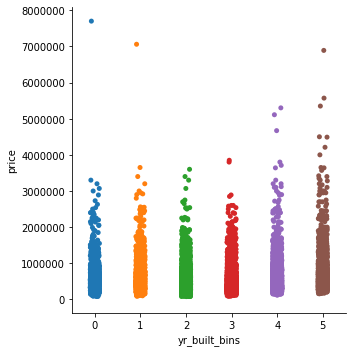

In [54]:
sns.catplot(x="yr_built_bins", y="price", data=df)

## Looks like with the exception of some outliers, most ranges of houses with regards to when they were built net about the same price

## Binning yr_renovated

In [55]:
sorted(df['yr_renovated'].unique())

[0.0,
 1934.0,
 1940.0,
 1944.0,
 1945.0,
 1946.0,
 1948.0,
 1950.0,
 1951.0,
 1953.0,
 1954.0,
 1955.0,
 1956.0,
 1957.0,
 1958.0,
 1959.0,
 1960.0,
 1962.0,
 1963.0,
 1964.0,
 1965.0,
 1967.0,
 1968.0,
 1969.0,
 1970.0,
 1971.0,
 1972.0,
 1973.0,
 1974.0,
 1975.0,
 1976.0,
 1977.0,
 1978.0,
 1979.0,
 1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0]

In [56]:
ren_bins = [0, 1900,1940,1960,1980,2000,2020]

In [57]:
df['yr_ren_bins'] = pd.cut(df['yr_renovated'], ren_bins,include_lowest=True)
df['yr_ren_bins'].value_counts()

(-0.001, 1900.0]    20853
(2000.0, 2020.0]      350
(1980.0, 2000.0]      288
(1960.0, 1980.0]       78
(1940.0, 1960.0]       25
(1900.0, 1940.0]        3
Name: yr_ren_bins, dtype: int64

In [58]:
df['yr_ren_bins']= df['yr_ren_bins'].astype("category")

In [59]:
df['yr_ren_bins'] = df['yr_ren_bins'].cat.codes

In [60]:
df['yr_ren_bins'].value_counts(dropna=False)

0    20853
5      350
4      288
3       78
2       25
1        3
Name: yr_ren_bins, dtype: int64

In [61]:
df.drop('yr_renovated',axis=1, inplace=True)

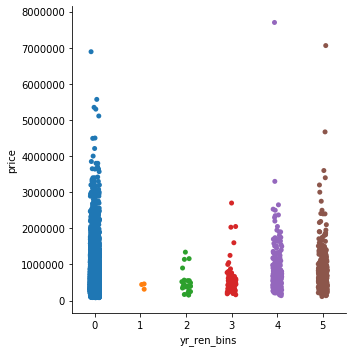

In [62]:
sns.catplot(x="yr_ren_bins", y="price", data=df)

## In this data, most of the renovated houses are in the 5th bin, 2000-2020 and fetch the highest prices

## Examining data visually before trimming outliers

In [63]:
def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.title(variable)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(variable)
    
    plt.tight_layout()
    plt.show()

## TBD: DO PLOTS FOR CATEGORICAL VS. NUMERICAL FEATURES AS DIFFERENT PLOTS FOR DISTRIBUTION BY THEMSELVES/AGAINST PRICE

In [64]:
numeric_col = ['price', 'sqft_living', 'sqft_lot', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'yr_built_bins', 'yr_ren_bins']

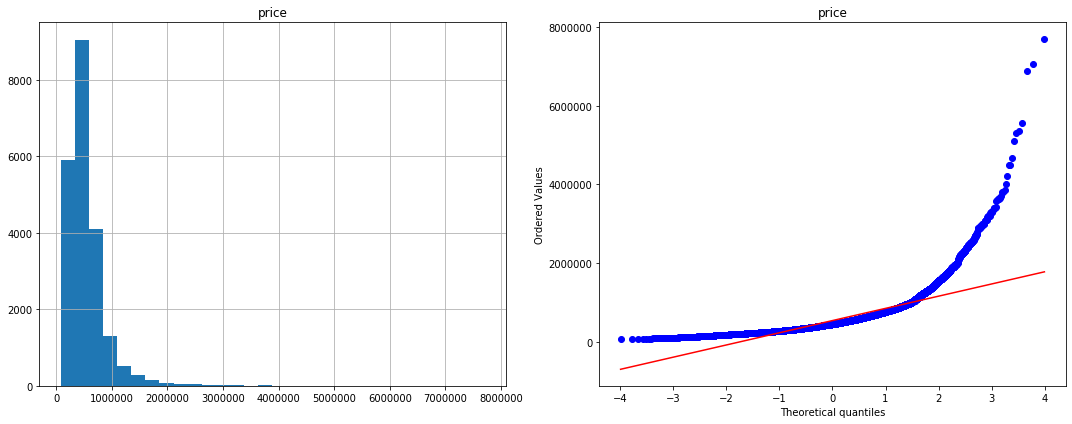

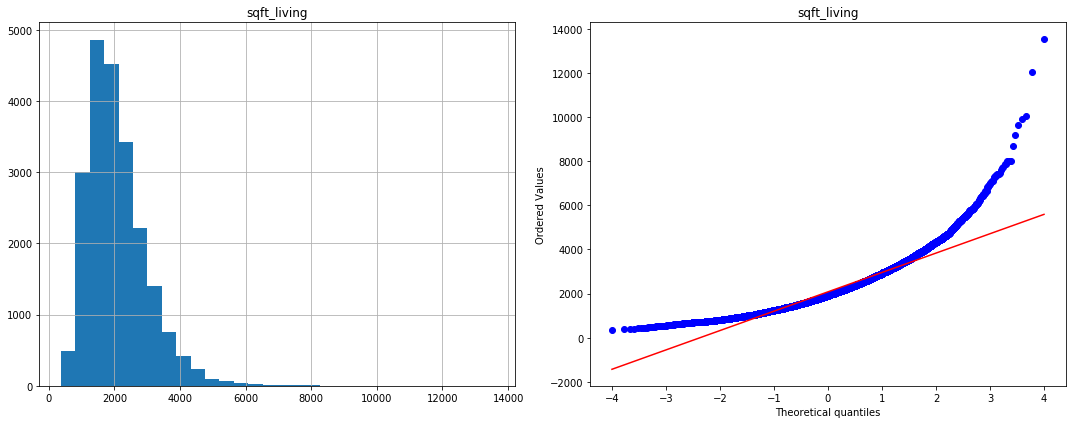

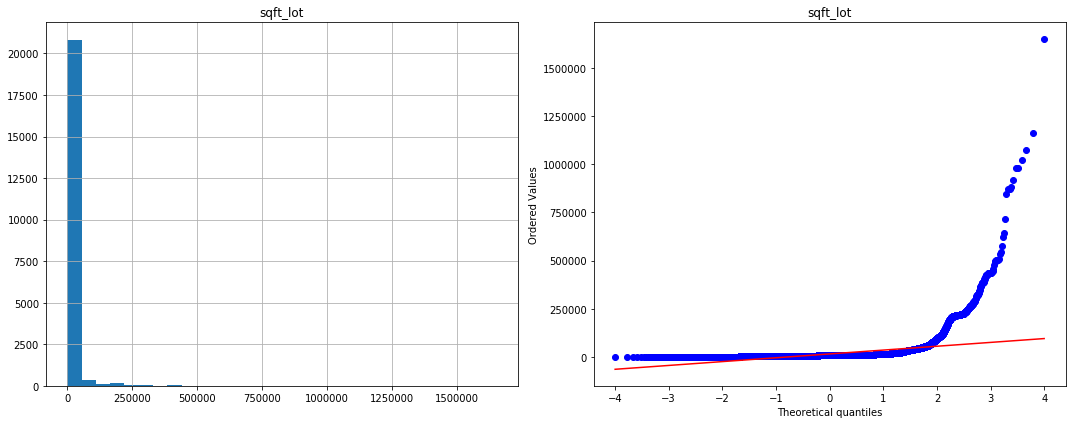

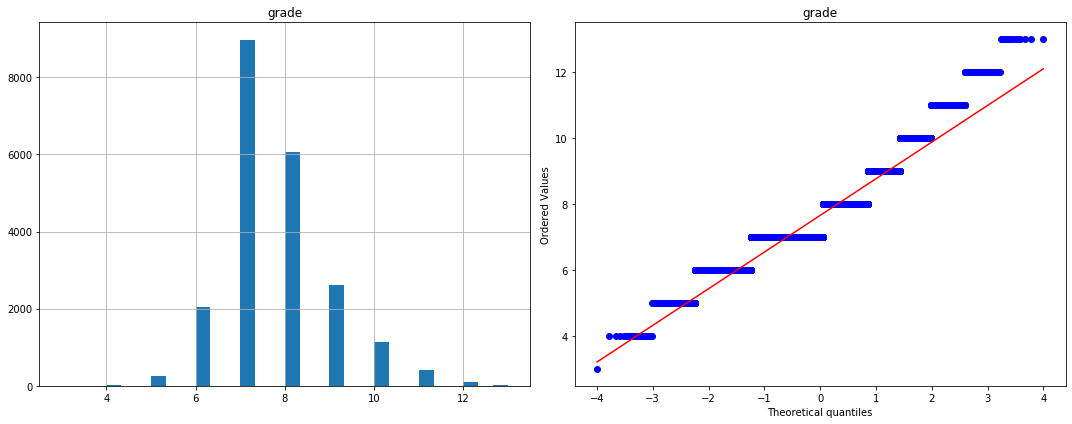

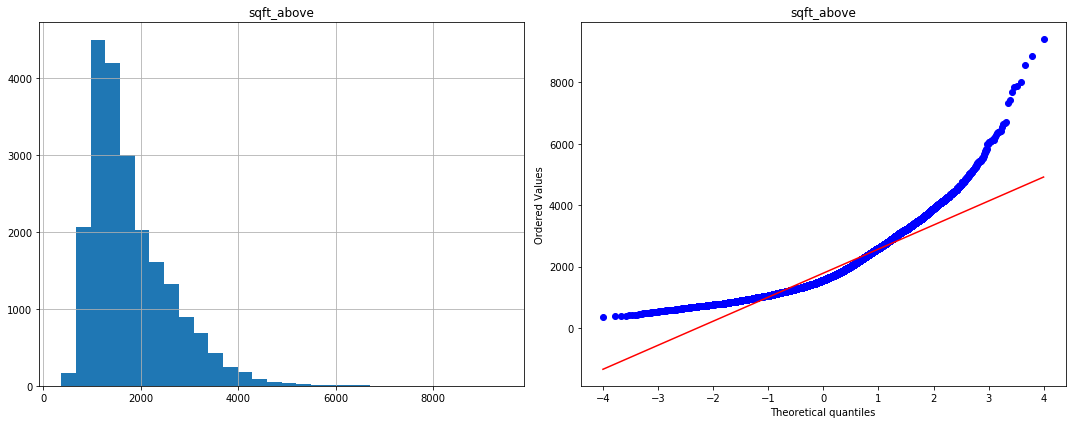

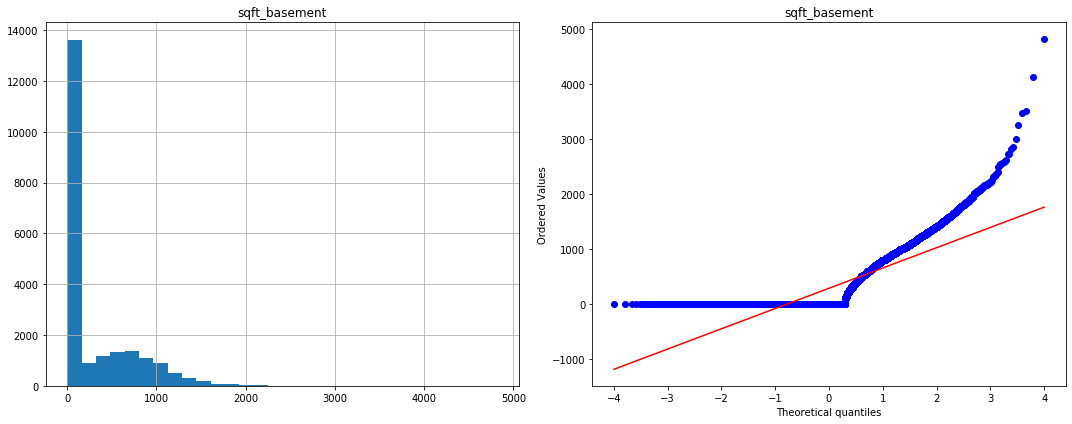

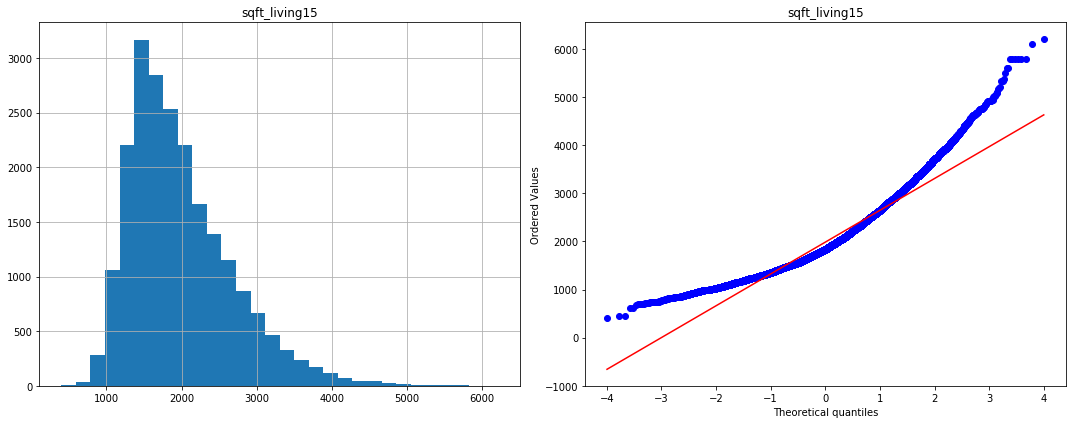

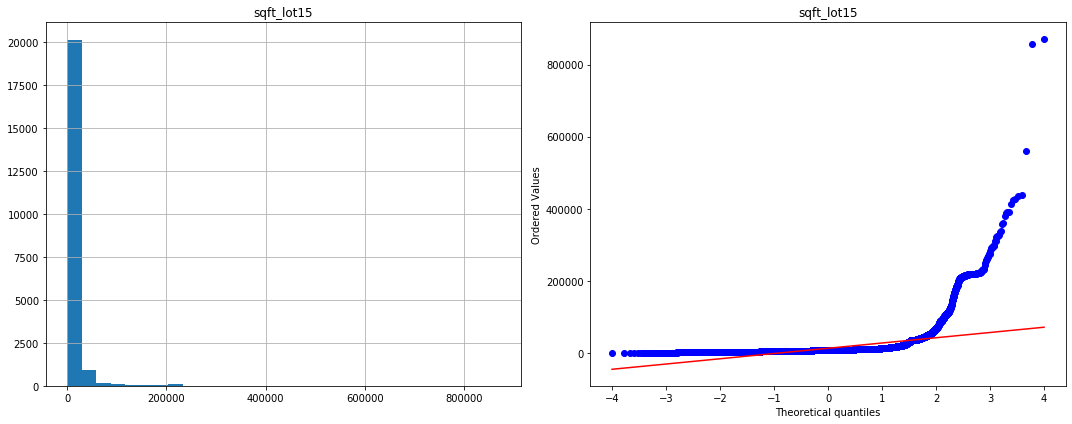

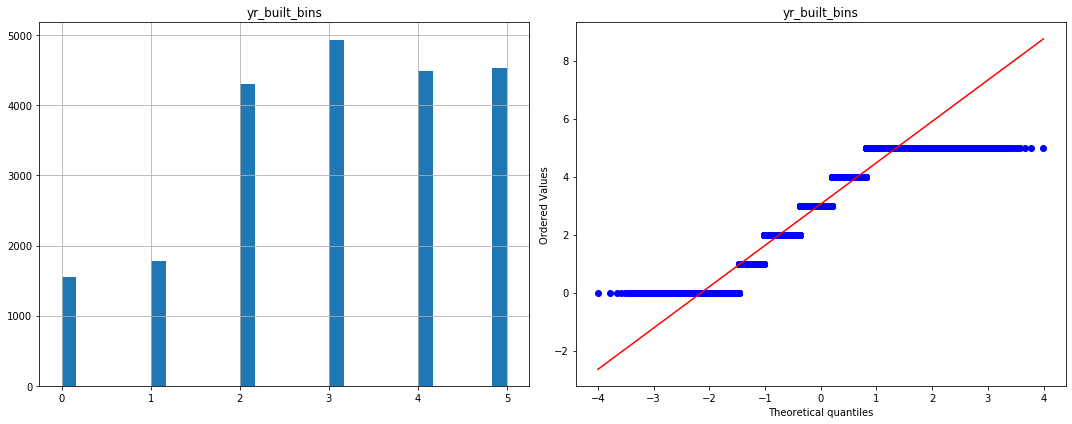

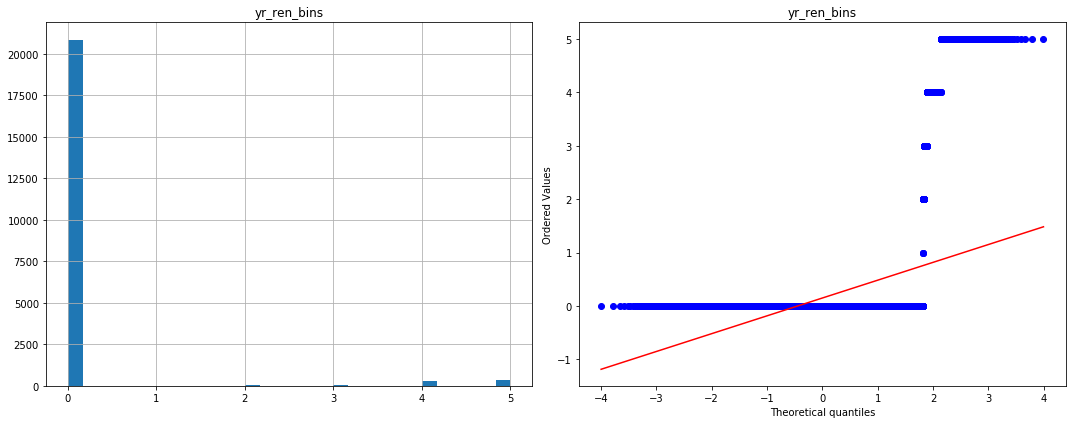

In [65]:
for col in df[numeric_col]:
    diagnostic_plots(df,col)

## This plot is very finicky about number of features

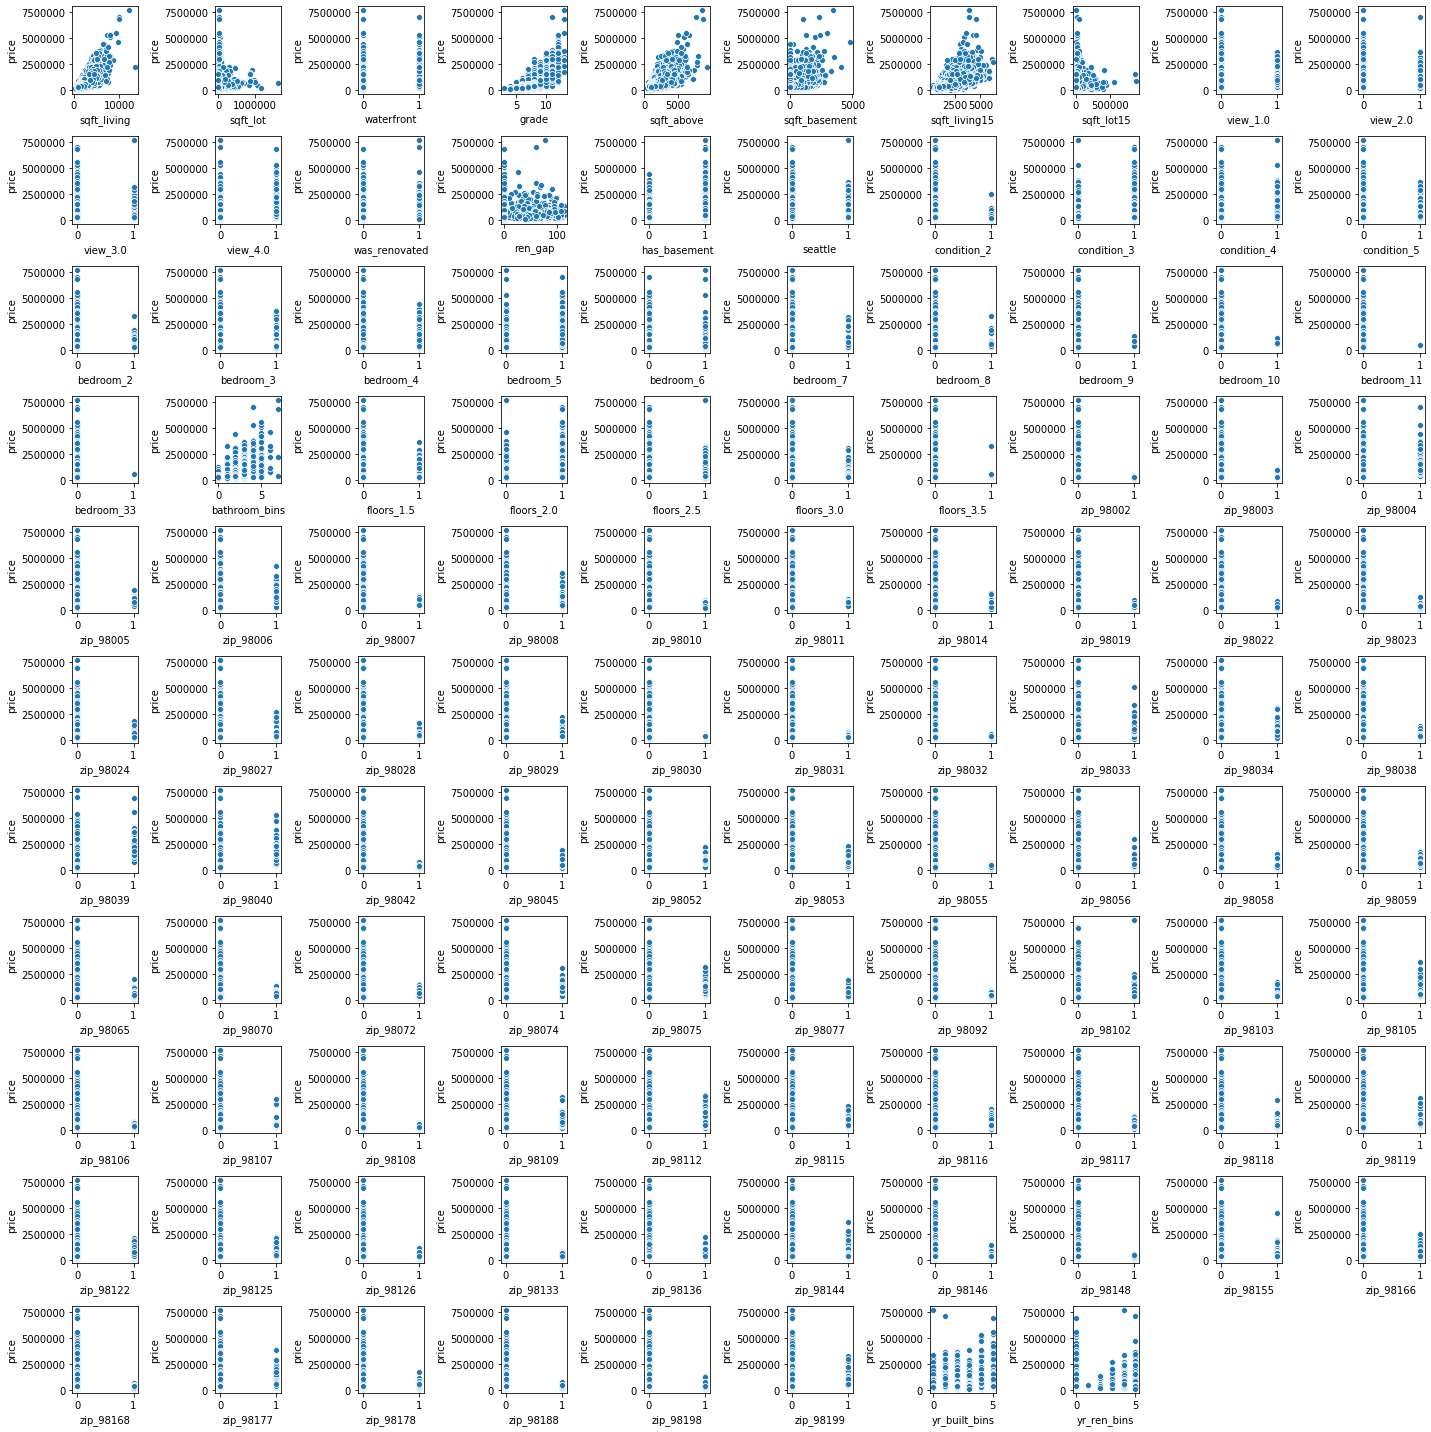

In [66]:
#set figures large to be modified by tight_layout
plt.figure(1, figsize=(20,20))

#core function to create scatterplot
def multi_scatter_plot(x):
    sns.scatterplot(x, y="price", data=df)
    
#iterating over dataframe minus redundant price column, adding subplots
for index, col in enumerate(df.drop(['price'], axis=1).columns, start=1):
    #adds subplot, using index to increment position of new subplot in a 5 column structure
    plt.subplot(11, 10,index)
    #call function to create plot
    multi_scatter_plot(col)
    
#tidy display for inline and show plot
plt.tight_layout()
plt.show()

In [67]:
df.drop(['sqft_lot', 'sqft_lot15', 'ren_gap'], axis=1, inplace=True)

In [68]:
len(df)

21597

In [69]:

def find_outliers(col):
    """Use scipy to calcualte absoliute Z-scores 
    and return boolean series where True indicates it is an outlier
    Args:
        col (Series): a series/column from your DataFrame
    Returns:
        idx_outliers (Series): series of  True/False for each row in col
        
    Ex:
    >> idx_outs = find_outliers(df['bedrooms'])
    >> df_clean = df.loc[idx_outs==False]"""
    from scipy import stats
    z = np.abs(stats.zscore(col))
    idx_outliers = np.where(z>3,True,False)
    return pd.Series(idx_outliers,index=col.index)

In [70]:
df.columns

Index(['price', 'sqft_living', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'view_1.0', 'view_2.0', 'view_3.0',
       ...
       'zip_98155', 'zip_98166', 'zip_98168', 'zip_98177', 'zip_98178',
       'zip_98188', 'zip_98198', 'zip_98199', 'yr_built_bins', 'yr_ren_bins'],
      dtype='object', length=106)

In [71]:
col_trim = ['price', 'sqft_living', 
            'grade', 'sqft_above', 'sqft_basement','sqft_living15'] 

for col in col_trim:
    print(col)
    idx = find_outliers(df[col])
    df = df.loc[idx==False]

price
sqft_living
grade
sqft_above
sqft_basement
sqft_living15


In [72]:
len(df)

20269

In [73]:
df.columns

Index(['price', 'sqft_living', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'view_1.0', 'view_2.0', 'view_3.0',
       ...
       'zip_98155', 'zip_98166', 'zip_98168', 'zip_98177', 'zip_98178',
       'zip_98188', 'zip_98198', 'zip_98199', 'yr_built_bins', 'yr_ren_bins'],
      dtype='object', length=106)

## Dropping all only 1s and only 0s columns

In [74]:
df = df.loc[:, (df != 0).any(axis=0)]

df.columns

Index(['price', 'sqft_living', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'view_1.0', 'view_2.0', 'view_3.0',
       ...
       'zip_98155', 'zip_98166', 'zip_98168', 'zip_98177', 'zip_98178',
       'zip_98188', 'zip_98198', 'zip_98199', 'yr_built_bins', 'yr_ren_bins'],
      dtype='object', length=106)

In [75]:
display(df.columns)

Index(['price', 'sqft_living', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'view_1.0', 'view_2.0', 'view_3.0',
       ...
       'zip_98155', 'zip_98166', 'zip_98168', 'zip_98177', 'zip_98178',
       'zip_98188', 'zip_98198', 'zip_98199', 'yr_built_bins', 'yr_ren_bins'],
      dtype='object', length=106)

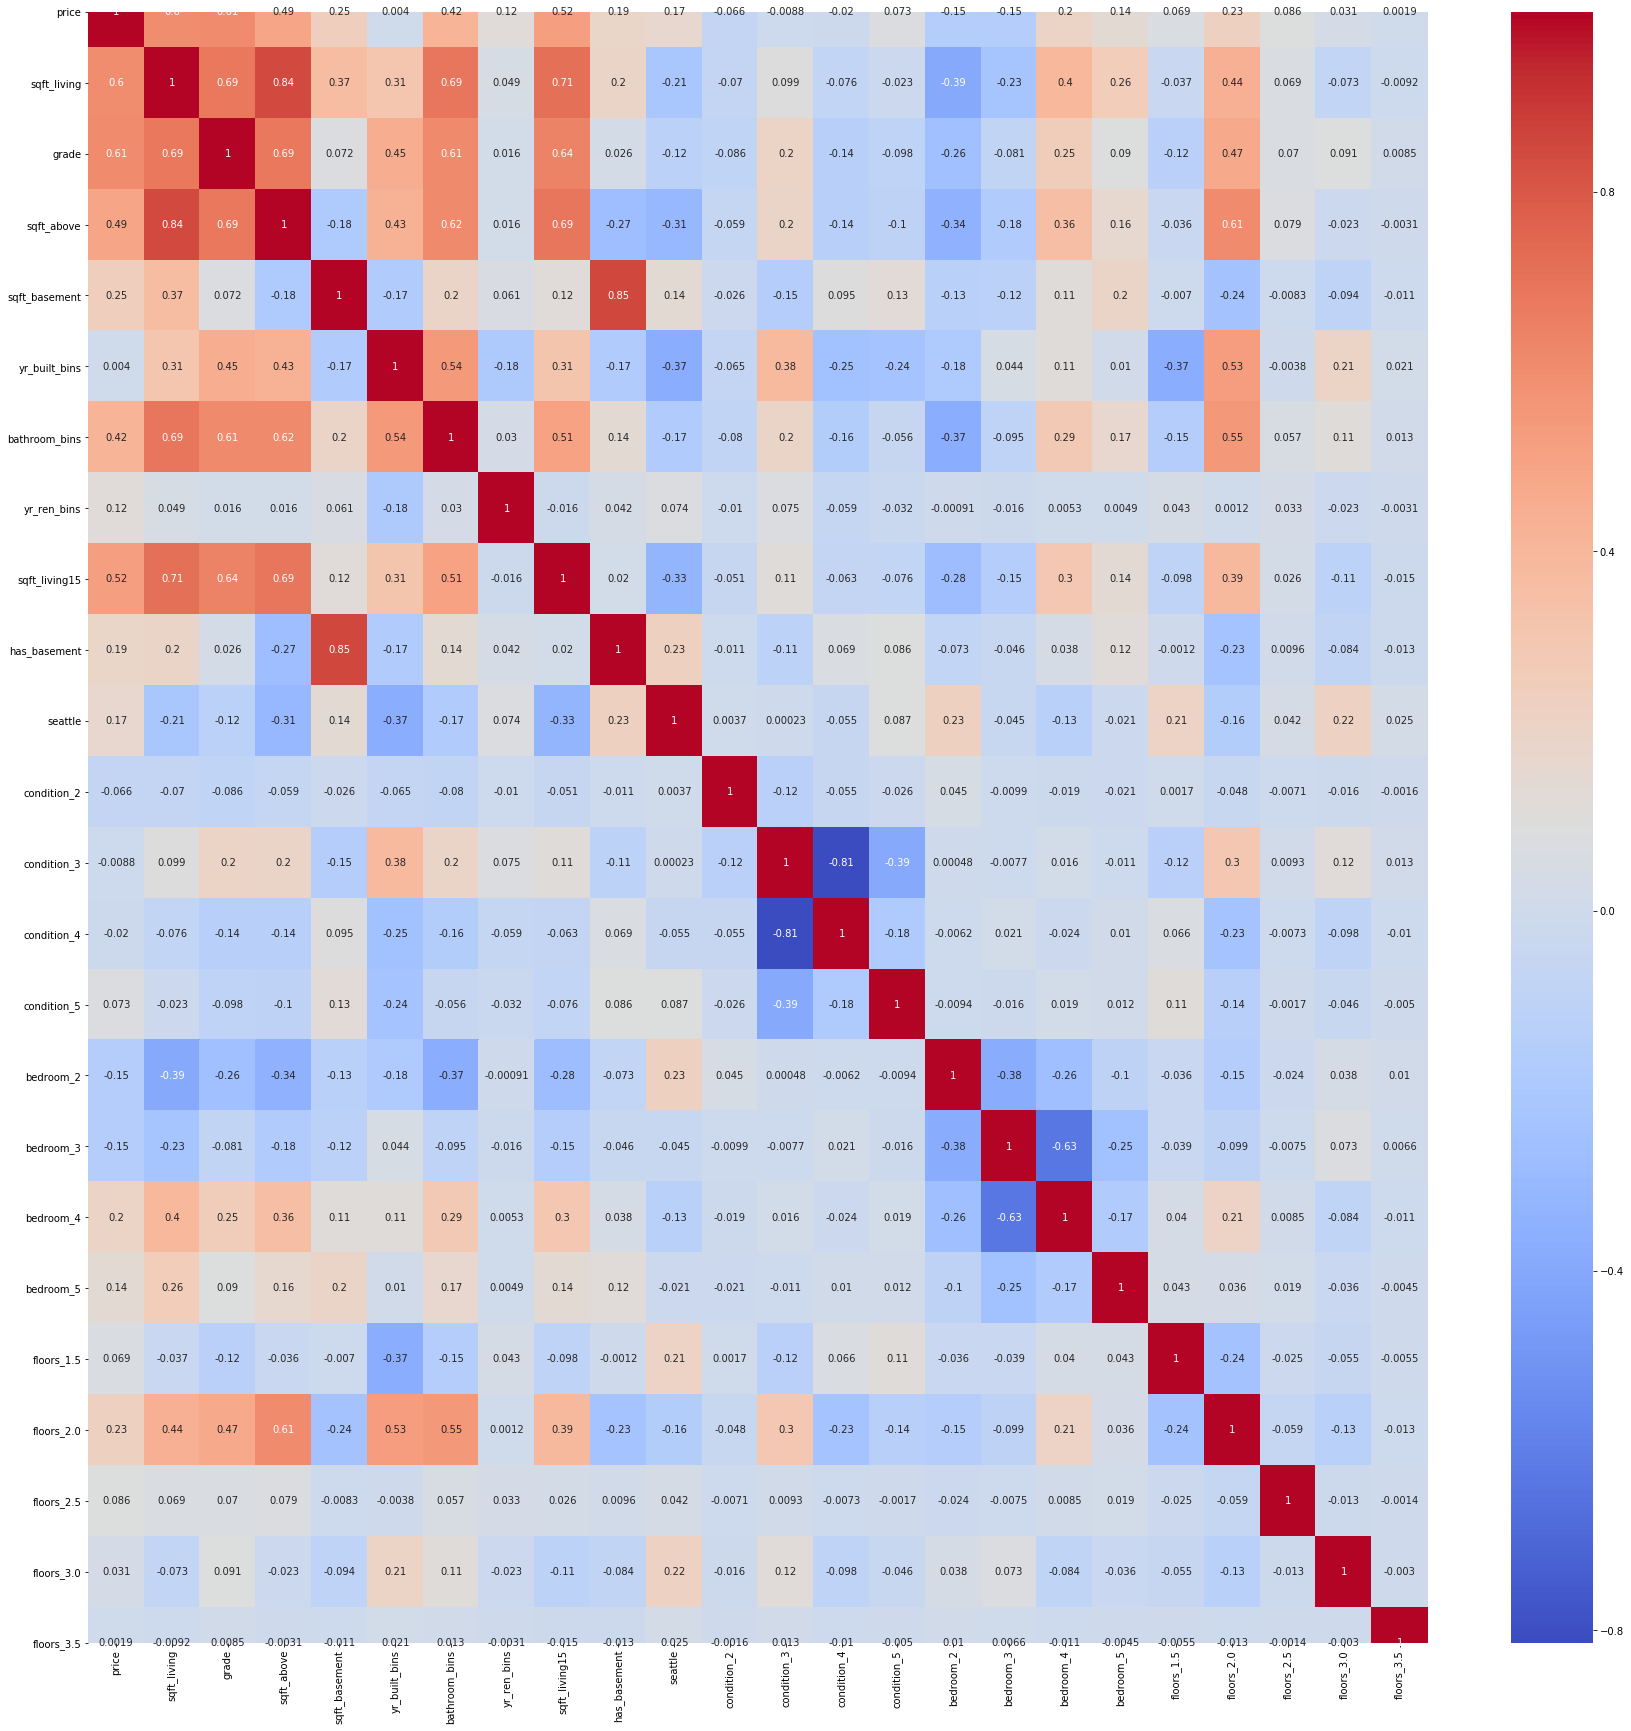

In [76]:
## Comment out large viz if needing the notebook to run quickly

plt.figure(figsize=(30,30))
plt.tight_layout()
sns.heatmap(df[['price', 'sqft_living',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built_bins', 'bathroom_bins', 'yr_ren_bins',
       'sqft_living15',
       'has_basement', 'seattle', 'condition_2', 'condition_3',
       'condition_4', 'condition_5',
       'bedroom_2', 'bedroom_3', 'bedroom_4', 'bedroom_5',
       'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0',
       'floors_3.5']].corr(), cmap='coolwarm', annot=True);

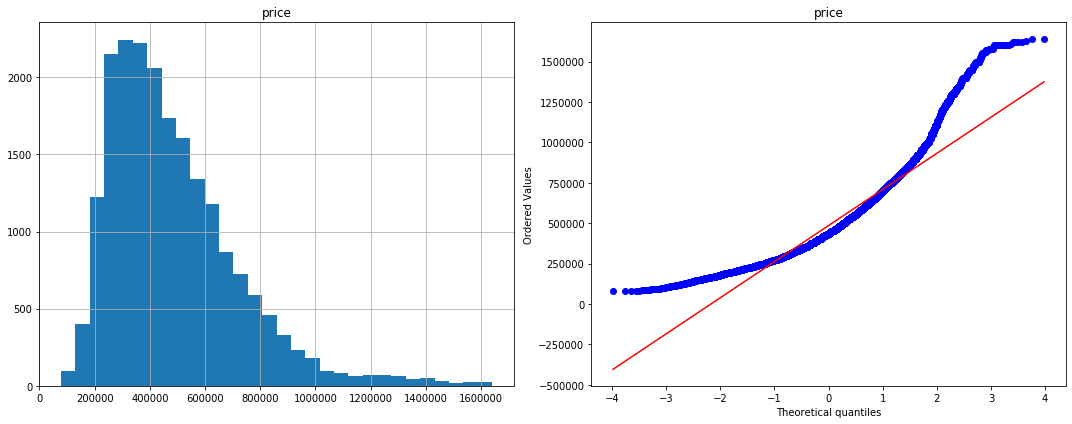

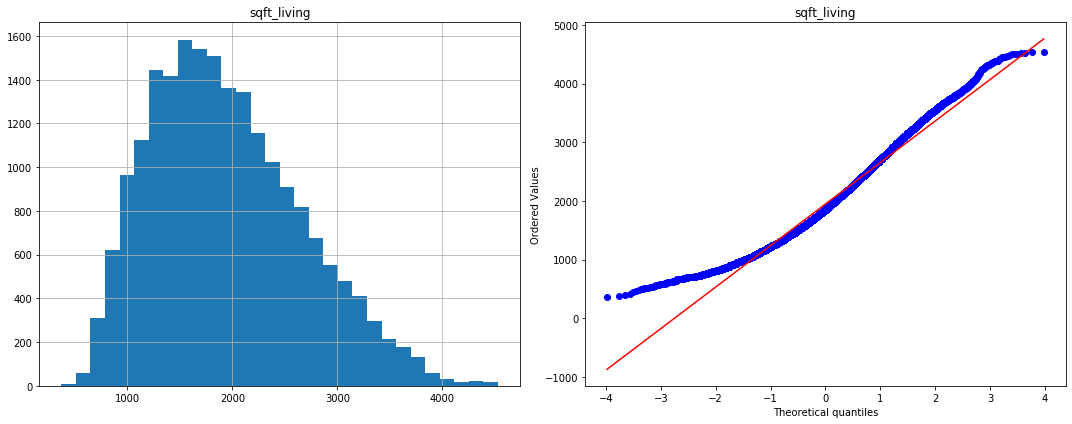

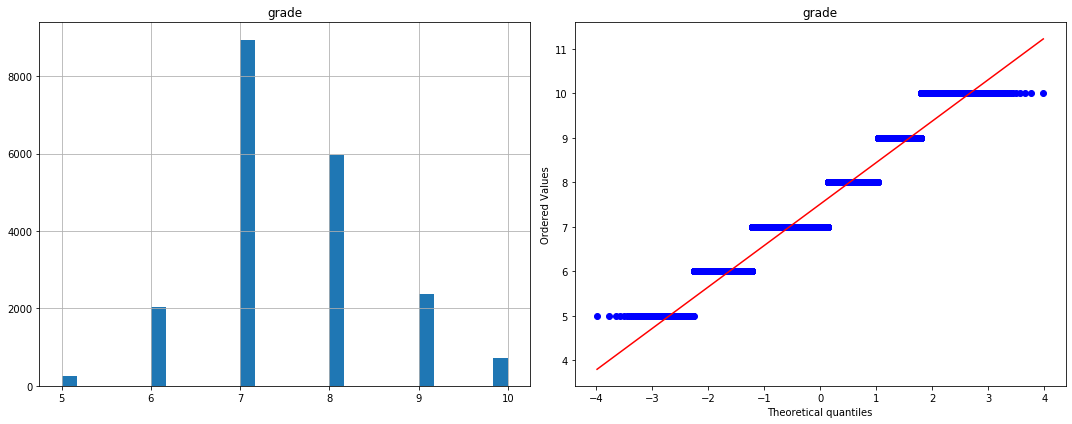

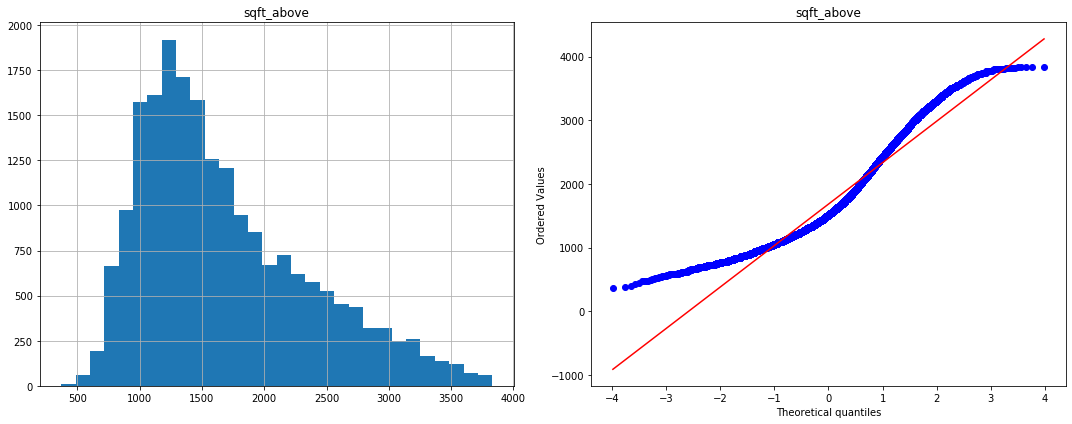

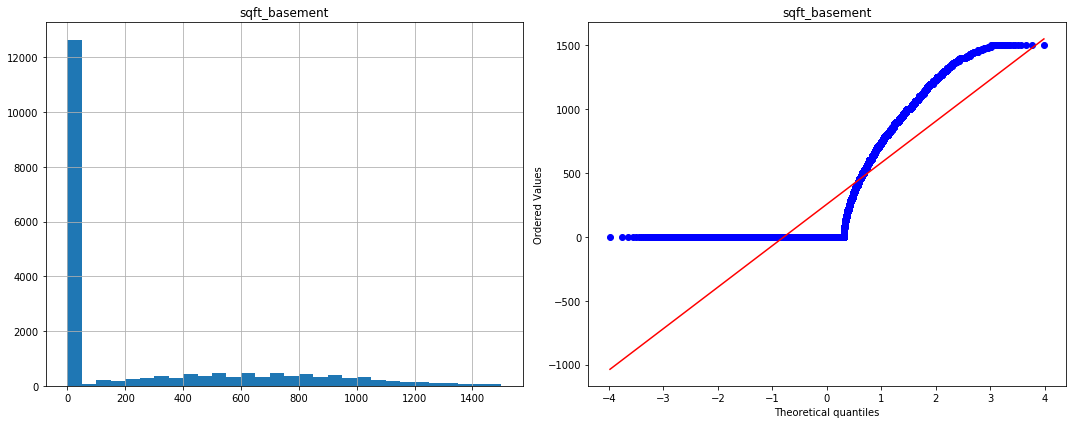

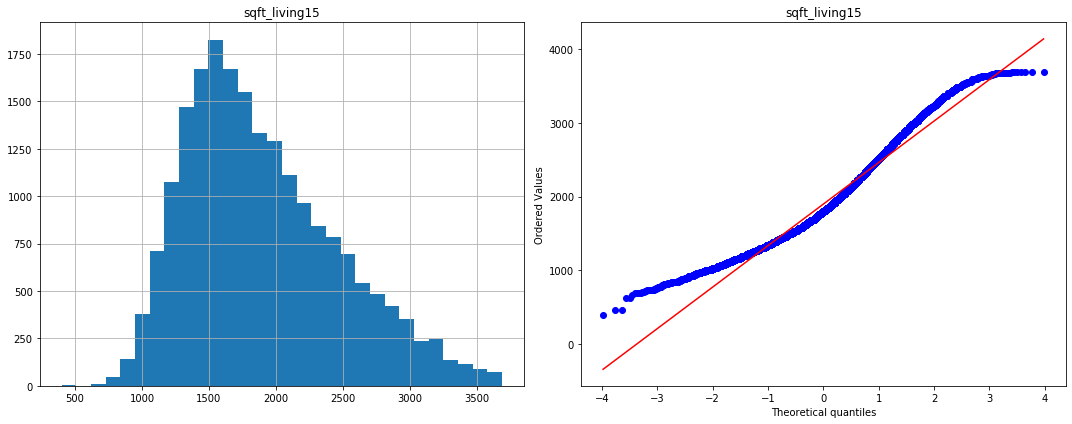

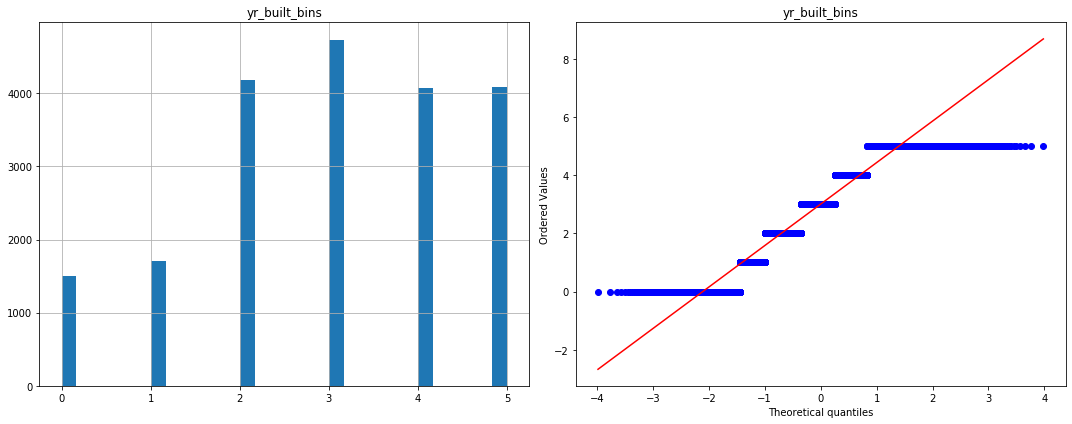

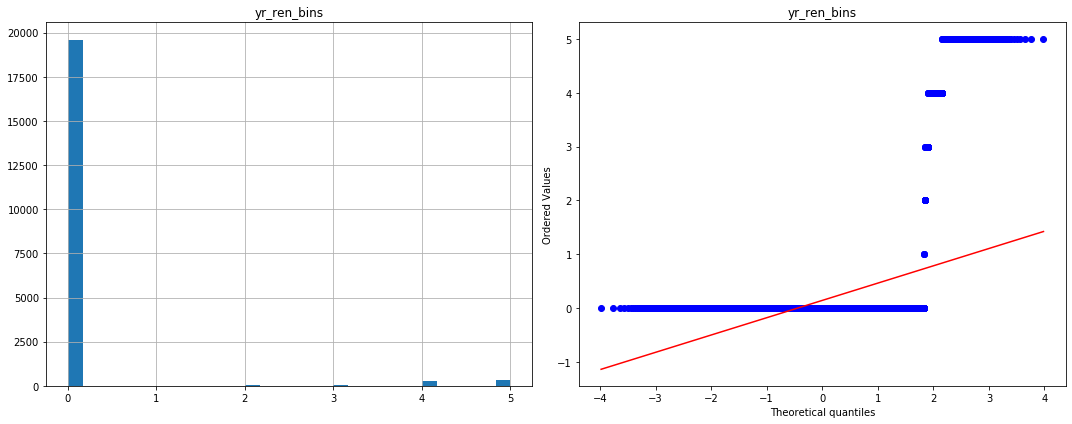

In [77]:
numeric_col = ['price', 'sqft_living',  'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15',  'yr_built_bins', 'yr_ren_bins']

for col in df[numeric_col]:
    diagnostic_plots(df,col)

## TBD/ NOTE: DETERMINE WHAT TO LOG TRANSFORM BASED ON DISTRIBUTION

In [78]:
df.columns

Index(['price', 'sqft_living', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'view_1.0', 'view_2.0', 'view_3.0',
       ...
       'zip_98155', 'zip_98166', 'zip_98168', 'zip_98177', 'zip_98178',
       'zip_98188', 'zip_98198', 'zip_98199', 'yr_built_bins', 'yr_ren_bins'],
      dtype='object', length=106)

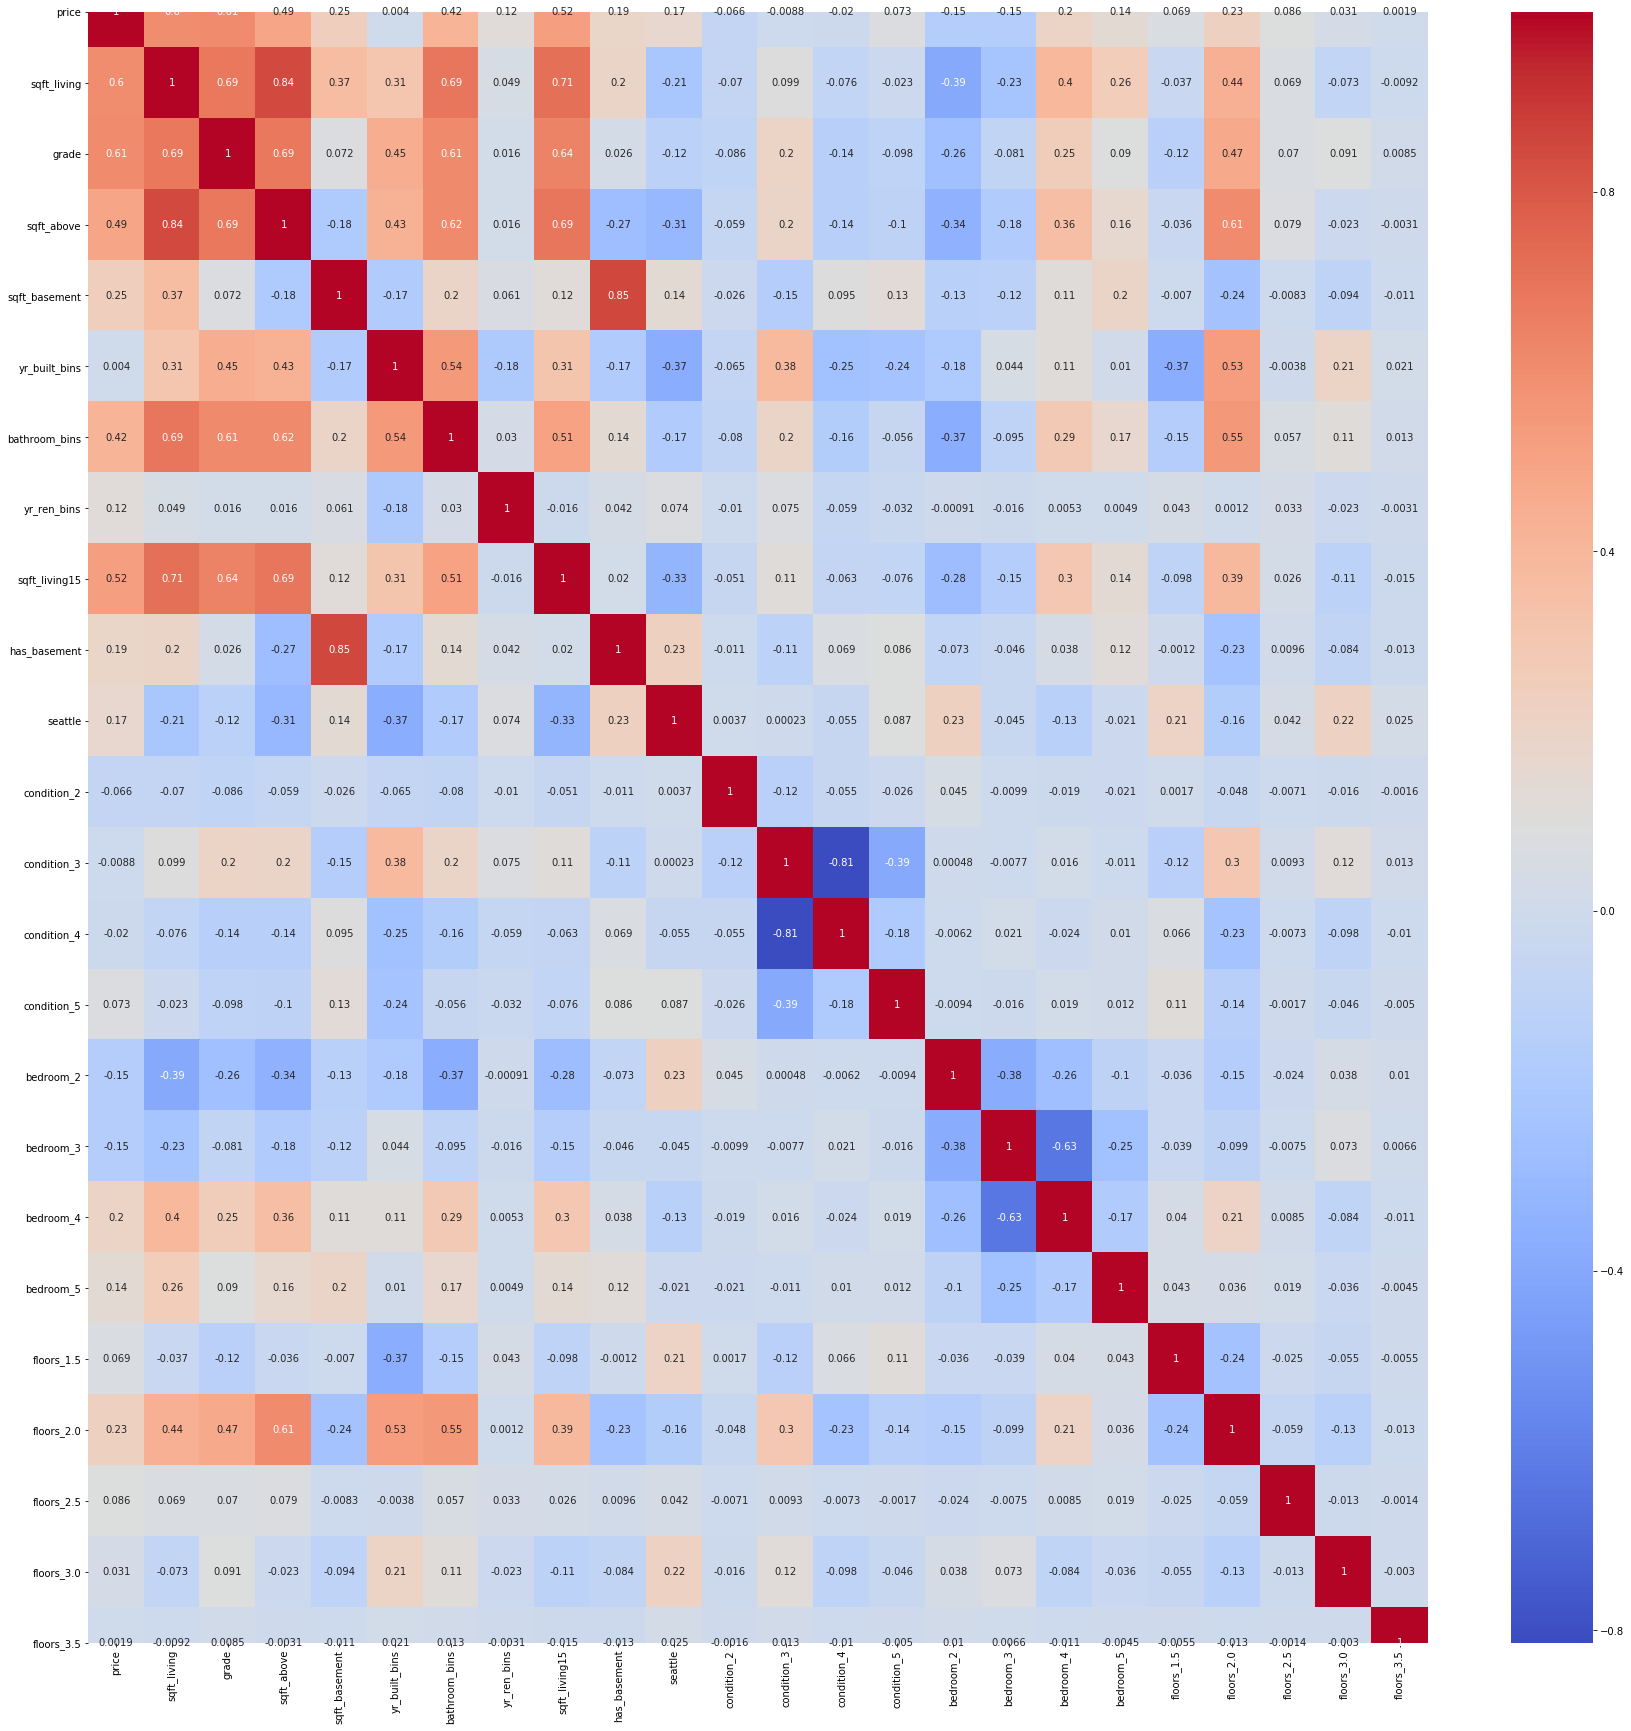

In [79]:
# Comment out if needed to run quickly

plt.figure(figsize=(30,30))
plt.tight_layout()
sns.heatmap(df[['price', 'sqft_living',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built_bins', 'bathroom_bins', 'yr_ren_bins',
       'sqft_living15',
       'has_basement', 'seattle', 'condition_2', 'condition_3',
       'condition_4', 'condition_5',
       'bedroom_2', 'bedroom_3', 'bedroom_4', 'bedroom_5',
       'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0',
       'floors_3.5']].corr(), cmap='coolwarm', annot=True);

In [80]:
df.drop('bedroom_3', axis=1, inplace=True)

In [81]:
df.head()

,price,sqft_living,waterfront,grade,sqft_above,sqft_basement,sqft_living15,view_1.0,view_2.0,view_3.0,...,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,yr_built_bins,yr_ren_bins
0,221900.0,1180,0.0,7,1180,0,1340,0,0,0,...,0,0,0,0,1,0,0,0,2,0
1,538000.0,2570,0.0,7,2170,400,1690,0,0,0,...,0,0,0,0,0,0,0,0,2,4
2,180000.0,770,0.0,6,770,0,2720,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,604000.0,1960,0.0,7,1050,910,1360,0,0,0,...,0,0,0,0,0,0,0,0,3,0
4,510000.0,1680,0.0,8,1680,0,1800,0,0,0,...,0,0,0,0,0,0,0,0,4,0


In [82]:
len(df.columns)

105

## Scaling with MinMax, TBD: add kde plots

In [83]:
df.columns

Index(['price', 'sqft_living', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'view_1.0', 'view_2.0', 'view_3.0',
       ...
       'zip_98155', 'zip_98166', 'zip_98168', 'zip_98177', 'zip_98178',
       'zip_98188', 'zip_98198', 'zip_98199', 'yr_built_bins', 'yr_ren_bins'],
      dtype='object', length=105)

## Should this be done after test train split?

In [84]:
scale_cols= ['price', 'sqft_living', 'grade', 'yr_built_bins', 'bathroom_bins', 'yr_ren_bins']
scaler = MinMaxScaler()

df[scale_cols] = scaler.fit_transform(df[scale_cols])

df.head(10)

,price,sqft_living,waterfront,grade,sqft_above,sqft_basement,sqft_living15,view_1.0,view_2.0,view_3.0,...,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,yr_built_bins,yr_ren_bins
0,0.092125,0.194712,0.0,0.4,1180,0,1340,0,0,0,...,0,0,0,0,1,0,0,0,0.4,0.0
1,0.294494,0.528846,0.0,0.4,2170,400,1690,0,0,0,...,0,0,0,0,0,0,0,0,0.4,0.8
2,0.065301,0.096154,0.0,0.2,770,0,2720,0,0,0,...,0,0,0,0,0,0,0,0,0.2,0.0
3,0.336748,0.382212,0.0,0.4,1050,910,1360,0,0,0,...,0,0,0,0,0,0,0,0,0.6,0.0
4,0.276569,0.314904,0.0,0.6,1680,0,1800,0,0,0,...,0,0,0,0,0,0,0,0,0.8,0.0
6,0.114917,0.323317,0.0,0.4,1715,0,2238,0,0,0,...,0,0,0,0,0,0,0,0,0.8,0.0
7,0.136908,0.165865,0.0,0.4,1060,0,1650,0,0,0,...,0,0,0,0,0,0,1,0,0.6,0.0
8,0.096991,0.338942,0.0,0.4,1050,730,1780,0,0,0,...,0,0,0,0,0,0,0,0,0.4,0.0
9,0.156850,0.365385,0.0,0.4,1890,0,2390,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
11,0.249680,0.189904,0.0,0.4,860,300,1330,0,0,0,...,0,0,0,0,0,0,0,0,0.4,0.0


## Modeling with Ordinary Least Squares with SM for better stats analysis of regression

In [85]:
print(df.columns)

Index(['price', 'sqft_living', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'view_1.0', 'view_2.0', 'view_3.0',
       ...
       'zip_98155', 'zip_98166', 'zip_98168', 'zip_98177', 'zip_98178',
       'zip_98188', 'zip_98198', 'zip_98199', 'yr_built_bins', 'yr_ren_bins'],
      dtype='object', length=105)


In [86]:
X = df.drop('price', axis=1)

y = df['price']

y = y.astype(float)
X = X.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=0)
x_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model_fit = sm.OLS(y_train, x_train).fit()
results_df = pd.concat([x_train, y_train], axis=1)
model_fit.summary()

C:\Users\reube\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     628.9
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        21:54:30   Log-Likelihood:                 18873.
No. Observations:               14188   AIC:                        -3.754e+04
Df Residuals:                   14085   BIC:                        -3.676e+04
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1525      0.015    -10.400      0.000      -0.181      -0.124
sqft_living       0.2136      0.031      6.808      0.000       0.152       0.275
waterfront        0.1320      0.011     12.240      0.000       0.111       0.153
grade             0.1562      0.005     32.614      0.000       0.147       0.166
sqft_above     3.666e-05   7.55e-06      4.857      0.000    2.19e-05    5.15e-05
sqft_basement  4.674e-06   7.92e-06      0.590      0.555   -1.08e-05    2.02e-05
sqft_living15  1.802e-05    1.6e-06     11.228      0.000    1.49e-05    2.12e-05
view_1.0          0.0409      0.005      8.506      0.000       0.031       0.050
view_2.0          0.0458      0.003     15.808      0.000       0.040       0.052
view_3.0          0.0938      0.004     22.043      0.000       0.085       0.102
view_4.0          0.1560      0.007     22.731      0.000       0.143       0.169
was_renovated    -0.0954      0.015     -6.166      0.000      -0.126      -0.065
has_basement     -0.0009      0.002     -0.379      0.705      -0.005       0.004
seattle           0.1778      0.004     42.363      0.000       0.170       0.186
condition_2       0.0403      0.015      2.728      0.006       0.011       0.069
condition_3       0.0477      0.014      3.520      0.000       0.021       0.074
condition_4       0.0602      0.014      4.436      0.000       0.034       0.087
condition_5       0.0858      0.014      6.278      0.000       0.059       0.113
bedroom_2         0.0026      0.002      1.419      0.156      -0.001       0.006
bedroom_4        -0.0049      0.001     -3.434      0.001      -0.008      -0.002
bedroom_5        -0.0097      0.003     -3.826      0.000      -0.015      -0.005
bedroom_6        -0.0256      0.006     -4.521      0.000      -0.037      -0.014
bedroom_7        -0.0490      0.015     -3.201      0.001      -0.079      -0.019
bedroom_8        -0.0874      0.026     -3.311      0.001      -0.139      -0.036
bedroom_9        -0.0207      0.032     -0.637      0.524      -0.084       0.043
bedroom_10       -0.1058      0.065     -1.641      0.101      -0.232       0.021
bedroom_11       -0.0252      0.064     -0.390      0.696      -0.152       0.101
bedroom_33     -3.87e-16   1.08e-15     -0.359      0.720    -2.5e-15    1.73e-15
bathroom_bins     0.0273      0.006      4.896      0.000       0.016       0.038
floors_1.5        0.0001      0.002      0.062      0.950      -0.004       0.004
floors_2.0       -0.0129      0.002     -6.788      0.000      -0.017      -0.009
floors_2.5        0.0029      0.007      0.398      0.691      -0.011       0.017
floors_3.0       -0.0353      0.004     -8.696      0.000      -0.043      -0.027
floors_3.5       -0.0533      0.032     -1.648      0.099      -0.117       0.010
zip_98002         0.0107      0.007      1.593   

In [87]:
predictions = model_fit.predict(X_test)
model_fit.conf_int()

,0,1
const,-0.181241,-0.123755
sqft_living,0.152123,0.275140
waterfront,0.110860,0.153136
grade,0.146803,0.165578
sqft_above,0.000022,0.000051
...,...,...
zip_98188,-0.168361,-0.143864
zip_98198,-0.001981,0.022309
zip_98199,0.053723,0.071343
yr_built_bins,-0.035332,-0.022701


## Predicitons analysis

Text(0, 0.5, 'Predicted Price')

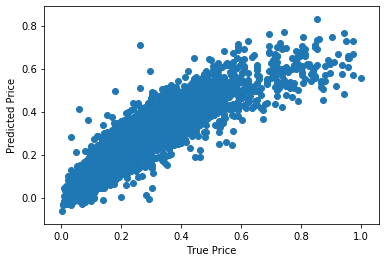

In [88]:
plt.scatter(y_test,predictions)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

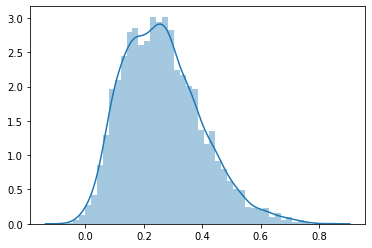

In [89]:
sns.distplot(predictions)

## Exponentionally transforming back the log transform as its inverse transformation - TBD: ONLY INCLUDE TRANSFORMED COLS

## Or add an explanation of log transformed features, that they are by percentage not unit

In [90]:
invert_log_pred = np.expm1(predictions)
invert_log_test= np.expm1(y_test)
invert_log_train = np.expm1(y_train)

Text(0, 0.5, 'Predicted Price - inverted log transform')

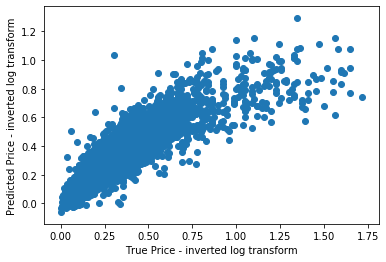

In [91]:
plt.scatter(invert_log_test,invert_log_pred)
plt.xlabel('True Price - inverted log transform')
plt.ylabel('Predicted Price - inverted log transform')

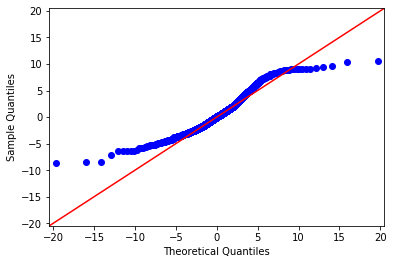

In [92]:
fig = sm.qqplot(model_fit.resid, stats.t, fit=True, line='45')
plt.show()

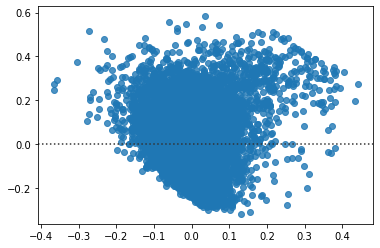

In [93]:
sns.residplot(model_fit.resid, model_fit.fittedvalues)

In [94]:
## Dropping high p values and re running model

In [95]:
df.drop(['bedroom_4', 'bedroom_5', 'bedroom_9', 'bedroom_11', 'floors_1.5','zip_98003', 'zip_98032' ], axis=1, inplace=True)

predictors = df.drop('price', axis=1)
target = df['price']


X_train, X_test, y_train, y_test = train_test_split(predictors,
                                                    target,
                                                    test_size=0.3,
                                                    random_state=0)
x_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model_fit = sm.OLS(y_train, x_train).fit()
results_df = pd.concat([x_train, y_train], axis=1)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     674.4
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        21:54:33   Log-Likelihood:                 18863.
No. Observations:               14188   AIC:                        -3.753e+04
Df Residuals:                   14092   BIC:                        -3.681e+04
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1530      0.014    -10.661      0.000      -0.181      -0.125
sqft_living       0.2013      0.031      6.443      0.000       0.140       0.263
waterfront        0.1324      0.011     12.271      0.000       0.111       0.154
grade             0.1586      0.005     33.394      0.000       0.149       0.168
sqft_above      3.73e-05   7.53e-06      4.955      0.000    2.25e-05    5.21e-05
sqft_basement  4.361e-06   7.92e-06      0.551      0.582   -1.12e-05    1.99e-05
sqft_living15  1.804e-05    1.6e-06     11.252      0.000    1.49e-05    2.12e-05
view_1.0          0.0414      0.005      8.617      0.000       0.032       0.051
view_2.0          0.0464      0.003     16.002      0.000       0.041       0.052
view_3.0          0.0946      0.004     22.251      0.000       0.086       0.103
view_4.0          0.1568      0.007     22.857      0.000       0.143       0.170
was_renovated    -0.0952      0.015     -6.159      0.000      -0.126      -0.065
has_basement     -0.0002      0.002     -0.091      0.927      -0.005       0.004
seattle           0.1784      0.003     58.162      0.000       0.172       0.184
condition_2       0.0400      0.015      2.709      0.007       0.011       0.069
condition_3       0.0476      0.014      3.507      0.000       0.021       0.074
condition_4       0.0601      0.014      4.428      0.000       0.033       0.087
condition_5       0.0856      0.014      6.266      0.000       0.059       0.112
bedroom_2         0.0032      0.002      1.748      0.081      -0.000       0.007
bedroom_6        -0.0207      0.006     -3.729      0.000      -0.032      -0.010
bedroom_7        -0.0439      0.015     -2.874      0.004      -0.074      -0.014
bedroom_8        -0.0807      0.026     -3.061      0.002      -0.132      -0.029
bedroom_10       -0.0996      0.065     -1.543      0.123      -0.226       0.027
bedroom_33    -4.839e-16   8.41e-16     -0.575      0.565   -2.13e-15    1.17e-15
bathroom_bins     0.0251      0.006      4.539      0.000       0.014       0.036
floors_2.0       -0.0128      0.002     -6.963      0.000      -0.016      -0.009
floors_2.5        0.0030      0.007      0.423      0.672      -0.011       0.017
floors_3.0       -0.0346      0.004     -8.577      0.000      -0.043      -0.027
floors_3.5       -0.0525      0.032     -1.622      0.105      -0.116       0.011
zip_98002         0.0114      0.006      1.878      0.060      -0.000       0.023
zip_98004         0.3824      0.006     62.980      0.000       0.370       0.394
zip_98005         0.2147      0.007     28.890      0.000       0.200       0.229
zip_98006         0.1701      0.005     34.626      0.000       0.160       0.180
zip_98007         0.1630      0.008     21.363      0.000       0.148       0.178
zip_98008         0.1557      0.005     28.422   

In [96]:
df.drop(['floors_3.0', 'zip_98011','zip_98028','zip_98065','zip_98077','zip_98155'], axis=1, inplace=True)

predictors = df.drop('price', axis=1)
target = df['price']


X_train, X_test, y_train, y_test = train_test_split(predictors,
                                                    target,
                                                    test_size=0.3,
                                                    random_state=0)
x_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model_fit = sm.OLS(y_train, x_train).fit()
results_df = pd.concat([x_train, y_train], axis=1)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     679.3
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        21:54:33   Log-Likelihood:                 18525.
No. Observations:               14188   AIC:                        -3.687e+04
Df Residuals:                   14098   BIC:                        -3.619e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0910      0.014     -6.284      0.000      -0.119      -0.063
sqft_living       0.2220      0.032      6.958      0.000       0.159       0.285
waterfront        0.1327      0.011     12.015      0.000       0.111       0.154
grade             0.1571      0.005     32.585      0.000       0.148       0.167
sqft_above     3.201e-05   7.68e-06      4.165      0.000    1.69e-05    4.71e-05
sqft_basement  1.039e-06    8.1e-06      0.128      0.898   -1.48e-05    1.69e-05
sqft_living15  2.166e-05   1.62e-06     13.354      0.000    1.85e-05    2.48e-05
view_1.0          0.0396      0.005      8.038      0.000       0.030       0.049
view_2.0          0.0446      0.003     15.054      0.000       0.039       0.050
view_3.0          0.0926      0.004     21.289      0.000       0.084       0.101
view_4.0          0.1524      0.007     21.713      0.000       0.139       0.166
was_renovated    -0.0986      0.016     -6.237      0.000      -0.130      -0.068
has_basement      0.0020      0.002      0.857      0.391      -0.003       0.007
seattle           0.1203      0.002     55.928      0.000       0.116       0.124
condition_2       0.0345      0.015      2.285      0.022       0.005       0.064
condition_3       0.0441      0.014      3.179      0.001       0.017       0.071
condition_4       0.0555      0.014      3.993      0.000       0.028       0.083
condition_5       0.0827      0.014      5.910      0.000       0.055       0.110
bedroom_2         0.0045      0.002      2.433      0.015       0.001       0.008
bedroom_6        -0.0209      0.006     -3.684      0.000      -0.032      -0.010
bedroom_7        -0.0407      0.016     -2.601      0.009      -0.071      -0.010
bedroom_8        -0.0804      0.027     -2.978      0.003      -0.133      -0.027
bedroom_10       -0.1058      0.066     -1.602      0.109      -0.235       0.024
bedroom_33     6.401e-15   4.08e-15      1.569      0.117    -1.6e-15    1.44e-14
bathroom_bins     0.0172      0.006      3.077      0.002       0.006       0.028
floors_2.0       -0.0061      0.002     -3.519      0.000      -0.009      -0.003
floors_2.5        0.0086      0.007      1.175      0.240      -0.006       0.023
floors_3.5       -0.0328      0.033     -0.993      0.321      -0.098       0.032
zip_98002        -0.0432      0.006     -7.453      0.000      -0.055      -0.032
zip_98004         0.3233      0.006     56.273      0.000       0.312       0.335
zip_98005         0.1575      0.007     21.757      0.000       0.143       0.172
zip_98006         0.1126      0.004     25.336      0.000       0.104       0.121
zip_98007         0.1062      0.007     14.234      0.000       0.092       0.121
zip_98008         0.1000      0.005     19.546      0.000       0.090       0.110
zip_98010         0.0076      0.008      0.932   

## High kurtosis indicates skew/outliers

## Stepwise forward-backward feature selection

In [97]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [98]:

result = stepwise_selection(predictors, target, verbose=True)
print('resulting features:')
print(result)

Add  sqft_living15                  with p-value 0.0
Add  seattle                        with p-value 0.0
Add  grade                          with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  zip_98004                      with p-value 0.0
Add  yr_built_bins                  with p-value 0.0
Add  zip_98040                      with p-value 8.12785e-192
Add  zip_98033                      with p-value 3.43958e-197
Add  view_4.0                       with p-value 1.32028e-132
Add  zip_98023                      with p-value 5.3664e-111
Add  zip_98112                      with p-value 2.92283e-94
Add  zip_98039                      with p-value 1.87436e-91
Add  zip_98052                      with p-value 2.25422e-86
Add  zip_98188                      with p-value 1.45021e-78
Add  zip_98006                      with p-value 4.10818e-76
Add  zip_98053                      with p-value 6.99551e-81
Add  zip_98133                      with p-value 7.72716e-79
Add  zip

In [103]:
df_stepwise = df[['grade', 'seattle', 'sqft_living', 'zip_98112', 'zip_98136', 'zip_98146', 'zip_98038', 'zip_98014', 'condition_4', 'zip_98058', 'zip_98024', 'condition_3', 'zip_98070', 'has_basement', 'zip_98010', 'zip_98055', 'zip_98119', 'zip_98105', 'zip_98109', 'zip_98178', 'zip_98116', 'zip_98148', 'zip_98002', 'zip_98092', 'zip_98199', 'zip_98107', 'condition_2', 'zip_98022', 'price']]


df_stepwise.head(10)

,grade,seattle,sqft_living,zip_98112,zip_98136,zip_98146,zip_98038,zip_98014,condition_4,zip_98058,...,zip_98178,zip_98116,zip_98148,zip_98002,zip_98092,zip_98199,zip_98107,condition_2,zip_98022,price
0,0.4,0,0.194712,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0.092125
1,0.4,1,0.528846,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.294494
2,0.2,0,0.096154,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.065301
3,0.4,1,0.382212,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.336748
4,0.6,0,0.314904,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.276569
6,0.4,0,0.323317,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.114917
7,0.4,0,0.165865,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.136908
8,0.4,0,0.338942,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.096991
9,0.4,0,0.365385,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.156850
11,0.4,1,0.189904,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.249680


## Model off of stepwise features

In [104]:
X_train, X_test, y_train, y_test = train_test_split(df_stepwise.drop('price', axis=1),
                                                    df_stepwise['price'],
                                                    test_size=0.3,
                                                    random_state=0)
x_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
    #fit model
model_fit = sm.OLS(y_train, x_train).fit()

    #store results in dataframe for easier analysis
#     results_df = pd.concat([x_train, y_train], axis=1)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     752.0
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        22:02:02   Log-Likelihood:                 13173.
No. Observations:               14188   AIC:                        -2.629e+04
Df Residuals:                   14159   BIC:                        -2.607e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0191      0.004      5.107      0.000       0.012       0.026
grade            0.2747      0.006     46.513      0.000       0.263       0.286
seattle          0.0603      0.002     28.696      0.000       0.056       0.064
sqft_living      0.3578      0.007     51.844      0.000       0.344       0.371
zip_98112        0.1575      0.008     20.203      0.000       0.142       0.173
zip_98136        0.0144      0.007      1.982      0.048       0.000       0.029
zip_98146        0.0076      0.007      1.103      0.270      -0.006       0.021
zip_98038       -0.0749      0.005    -15.236      0.000      -0.084      -0.065
zip_98014       -0.0062      0.011     -0.554      0.579      -0.028       0.016
condition_4     -0.0305      0.003     -9.381      0.000      -0.037      -0.024
zip_98058       -0.0782      0.005    -14.240      0.000      -0.089      -0.067
zip_98024        0.0132      0.014      0.934      0.350      -0.015       0.041
condition_3     -0.0625      0.003    -20.432      0.000      -0.068      -0.056
zip_98070        0.0231      0.011      2.158      0.031       0.002       0.044
has_basement    -0.0036      0.002     -1.949      0.051      -0.007    2.09e-05
zip_98010       -0.0302      0.012     -2.584      0.010      -0.053      -0.007
zip_98055       -0.0573      0.007     -8.151      0.000      -0.071      -0.044
zip_98119        0.1379      0.008     16.431      0.000       0.121       0.154
zip_98105        0.1129      0.008     13.969      0.000       0.097       0.129
zip_98109        0.1441      0.012     12.187      0.000       0.121       0.167
zip_98178       -0.0351      0.007     -4.711      0.000      -0.050      -0.020
zip_98116        0.0377      0.007      5.691      0.000       0.025       0.051
zip_98148       -0.0416      0.016     -2.636      0.008      -0.073      -0.011
zip_98002       -0.0790      0.008     -9.744      0.000      -0.095      -0.063
zip_98092       -0.1130      0.006    -17.909      0.000      -0.125      -0.101
zip_98199        0.0829      0.007     11.821      0.000       0.069       0.097
zip_98107        0.0471      0.007      6.355      0.000       0.033       0.062
condition_2     -0.0598      0.009     -6.415      0.000      -0.078      -0.042
zip_98022       -0.0672      0.008     -8.644      0.000      -0.082      -0.052
==============================================================================
Omnibus:                     3555.893   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13918.853
Skew:                           1.202   Prob(JB):                         0.00
Kurtosis:                       7.215   Cond. No.                         29.2
==============================================================================

Warnings:
[1] St

In [105]:
predictions = model_fit.predict(X_test)

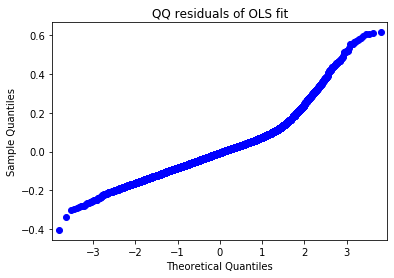

In [106]:
res = model_fit.resid # residuals
probplot = sm.ProbPlot(res)
fig = probplot.qqplot()
h = plt.title('QQ residuals of OLS fit')
plt.show()

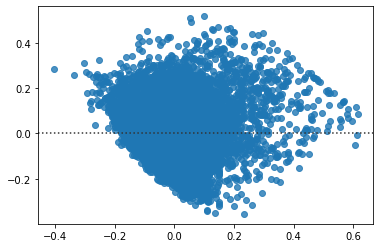

In [107]:
sns.residplot(model_fit.resid, model_fit.fittedvalues)

In [108]:
invert_log_pred = np.expm1(predictions)
invert_log_test= np.expm1(y_test)

In [109]:
invert_log_train = np.expm1(y_train)

Text(0, 0.5, 'Predicted Price - inverted log transform')

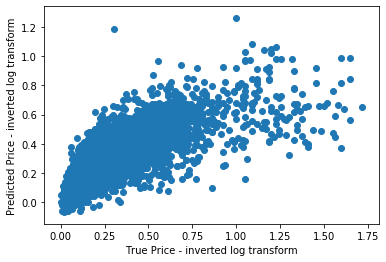

In [110]:
plt.scatter(invert_log_test,invert_log_pred)
plt.xlabel('True Price - inverted log transform')
plt.ylabel('Predicted Price - inverted log transform')

In [111]:
np.exp(model_fit.params)

const           1.019321
grade           1.316172
seattle         1.062173
sqft_living     1.430144
zip_98112       1.170582
zip_98136       1.014546
zip_98146       1.007646
zip_98038       0.927880
zip_98014       0.993771
condition_4     0.969975
zip_98058       0.924753
zip_98024       1.013314
condition_3     0.939432
zip_98070       1.023387
has_basement    0.996454
zip_98010       0.970284
zip_98055       0.944280
zip_98119       1.147912
zip_98105       1.119482
zip_98109       1.155025
zip_98178       0.965542
zip_98116       1.038452
zip_98148       0.959225
zip_98002       0.924048
zip_98092       0.893129
zip_98199       1.086459
zip_98107       1.048219
condition_2     0.941916
zip_98022       0.935034
dtype: float64

In [112]:
df.columns

Index(['price', 'sqft_living', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'view_1.0', 'view_2.0', 'view_3.0',
       'view_4.0', 'was_renovated', 'has_basement', 'seattle', 'condition_2',
       'condition_3', 'condition_4', 'condition_5', 'bedroom_2', 'bedroom_6',
       'bedroom_7', 'bedroom_8', 'bedroom_10', 'bedroom_33', 'bathroom_bins',
       'floors_2.0', 'floors_2.5', 'floors_3.5', 'zip_98002', 'zip_98004',
       'zip_98005', 'zip_98006', 'zip_98007', 'zip_98008', 'zip_98010',
       'zip_98014', 'zip_98019', 'zip_98022', 'zip_98023', 'zip_98024',
       'zip_98027', 'zip_98029', 'zip_98030', 'zip_98031', 'zip_98033',
       'zip_98034', 'zip_98038', 'zip_98039', 'zip_98040', 'zip_98042',
       'zip_98045', 'zip_98052', 'zip_98053', 'zip_98055', 'zip_98056',
       'zip_98058', 'zip_98059', 'zip_98070', 'zip_98072', 'zip_98074',
       'zip_98075', 'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105',
       'zip_98106', 'zip_98107', 'zip_9810

In [115]:
col_trim = ['price','sqft_living',
        'grade','has_basement', 'seattle', ] 


for col in col_trim:
    print(col)
    idx = find_outliers(df[col])
    df = df.loc[idx==False]

price
sqft_living
grade
has_basement
seattle


In [116]:
X_train, X_test, y_train, y_test = train_test_split(df_stepwise.drop('price', axis=1),
                                                    df_stepwise['price'],
                                                    test_size=0.3,
                                                    random_state=0)
x_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
    #fit model
model_fit = sm.OLS(y_train, x_train).fit()

    #store results in dataframe for easier analysis
#     results_df = pd.concat([x_train, y_train], axis=1)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     752.0
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        22:02:36   Log-Likelihood:                 13173.
No. Observations:               14188   AIC:                        -2.629e+04
Df Residuals:                   14159   BIC:                        -2.607e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0191      0.004      5.107      0.000       0.012       0.026
grade            0.2747      0.006     46.513      0.000       0.263       0.286
seattle          0.0603      0.002     28.696      0.000       0.056       0.064
sqft_living      0.3578      0.007     51.844      0.000       0.344       0.371
zip_98112        0.1575      0.008     20.203      0.000       0.142       0.173
zip_98136        0.0144      0.007      1.982      0.048       0.000       0.029
zip_98146        0.0076      0.007      1.103      0.270      -0.006       0.021
zip_98038       -0.0749      0.005    -15.236      0.000      -0.084      -0.065
zip_98014       -0.0062      0.011     -0.554      0.579      -0.028       0.016
condition_4     -0.0305      0.003     -9.381      0.000      -0.037      -0.024
zip_98058       -0.0782      0.005    -14.240      0.000      -0.089      -0.067
zip_98024        0.0132      0.014      0.934      0.350      -0.015       0.041
condition_3     -0.0625      0.003    -20.432      0.000      -0.068      -0.056
zip_98070        0.0231      0.011      2.158      0.031       0.002       0.044
has_basement    -0.0036      0.002     -1.949      0.051      -0.007    2.09e-05
zip_98010       -0.0302      0.012     -2.584      0.010      -0.053      -0.007
zip_98055       -0.0573      0.007     -8.151      0.000      -0.071      -0.044
zip_98119        0.1379      0.008     16.431      0.000       0.121       0.154
zip_98105        0.1129      0.008     13.969      0.000       0.097       0.129
zip_98109        0.1441      0.012     12.187      0.000       0.121       0.167
zip_98178       -0.0351      0.007     -4.711      0.000      -0.050      -0.020
zip_98116        0.0377      0.007      5.691      0.000       0.025       0.051
zip_98148       -0.0416      0.016     -2.636      0.008      -0.073      -0.011
zip_98002       -0.0790      0.008     -9.744      0.000      -0.095      -0.063
zip_98092       -0.1130      0.006    -17.909      0.000      -0.125      -0.101
zip_98199        0.0829      0.007     11.821      0.000       0.069       0.097
zip_98107        0.0471      0.007      6.355      0.000       0.033       0.062
condition_2     -0.0598      0.009     -6.415      0.000      -0.078      -0.042
zip_98022       -0.0672      0.008     -8.644      0.000      -0.082      -0.052
==============================================================================
Omnibus:                     3555.893   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13918.853
Skew:                           1.202   Prob(JB):                         0.00
Kurtosis:                       7.215   Cond. No.                         29.2
==============================================================================

Warnings:
[1] St

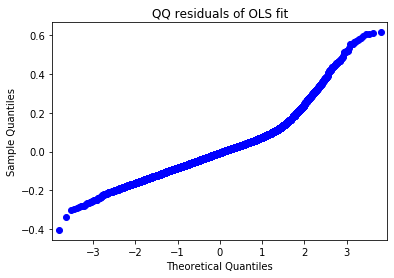

In [117]:
res = model_fit.resid # residuals
probplot = sm.ProbPlot(res)
fig = probplot.qqplot()
h = plt.title('QQ residuals of OLS fit')
plt.show()